In [468]:
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np
import os
from pathlib import Path
import math
from datetime import date,datetime
from getpass import getuser
import re
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
sns.set(style="whitegrid", context="talk")
import plotly.graph_objects as go
pd.set_option('display.max_columns', None)

***Directorio:***
+ _antmiguel_: directorio local considerando la estructura utilizada para el desarrollo de modelos
+ _jupyter_: directorio en el bucket del proyecto sandbox

In [469]:
def obtener_rutas_usuario(base_local: Path = None, base_remoto: str = None, usar_remoto: bool = False):
    """
    Devuelve las rutas de datos para el usuario actual, usando pathlib.
    Ajusta la ruta si estás ejecutando desde 'notebooks/', considerando la ruta relativa.

    Parámetros:
    - base_local: ruta base local donde se encuentran los datos, considerando la estructura cookiecutter (por defecto: '../data/')
    - base_remoto: ruta base remota tipo GCP, cuando estas en la VM
    - usar_remoto: True para rutas de cloud (base_remoto), False para rutas locales (base_local)

    Retorna:
    - dict con rutas: rawData, externalData, interimData, processedData
    """
    if base_local is None:
        try:
            base_local = Path(__file__).resolve().parent.parent / 'data'
        except NameError:
            base_local = Path.cwd()
            if 'notebooks' in base_local.parts:
                base_local = base_local.parent
            base_local = base_local / 'data'

    if base_remoto is None:
        base_remoto = 'gs://default-bucket/ScoreCI'

    if usar_remoto:
        rutas = {
            'rawData': f'{base_remoto}/raw/',
            'externalData': f'{base_remoto}/external/',
            'interimData': f'{base_remoto}/interim/',
            'processedData': f'{base_remoto}/processed/'
        }
    else:
        rutas = {
            'rawData': base_local / 'raw',
            'externalData': base_local / 'external',
            'interimData': base_local / 'interim',
            'processedData': base_local / 'processed'
        }

    return rutas

In [470]:
rutas = obtener_rutas_usuario()

In [471]:
rutas

{'rawData': WindowsPath('D:/Users/antmiguel/Repos/ent-sandbox-fdo-jupyter-repository/ScoreCI/data/raw'),
 'externalData': WindowsPath('D:/Users/antmiguel/Repos/ent-sandbox-fdo-jupyter-repository/ScoreCI/data/external'),
 'interimData': WindowsPath('D:/Users/antmiguel/Repos/ent-sandbox-fdo-jupyter-repository/ScoreCI/data/interim'),
 'processedData': WindowsPath('D:/Users/antmiguel/Repos/ent-sandbox-fdo-jupyter-repository/ScoreCI/data/processed')}

***Funciones:***

In [472]:
def generaCosecha(fecha):
    '''
    El parámetro de entrada es una fecha (datetime), y retorna un String con formato YYYYmm, 
    útil para hacer analisis de cosechas:
    Ejemplo:
    generaCosecha(date(2024,1,23)) ------>  '202401'
    
    '''
    if not isinstance(fecha, date):
        raise ValueError("La entrada debe ser un objeto de tipo date.")
    cosecha = fecha.strftime("%Y%m")
    return cosecha

def agregar_ceros(num, longitud):
    return str(num).zfill(longitud)

def sumar_lista(lista):
    return np.nansum(lista)

def merge_dataframes(*dataframes, on_column='ASESOR_ID'):
    if len(dataframes) < 2:
        raise ValueError("Se necesitan al menos dos DataFrames para fusionar.")
    df_merge = dataframes[0]
    for df in dataframes[1:]:
        df_merge = pd.merge(df_merge, df, on=on_column, how='inner')
    return df_merge

# Lectura de Datos

In [473]:
dfHist = pd.read_parquet(os.path.join(rutas.get('rawData'), 'ent-prd-sandbox-fdo-bucket_ScoreCI_raw_BaseAnaliticaHistorico_ScoreCI_08052025_abr25v6.parquet'))
dfCliente = pd.read_parquet(os.path.join(rutas.get('rawData'), 'ScoreCI_raw_BaseAnaliticaCliente_ScoreCI_02062025_abr25v6.parquet'))
dfAsesor = pd.read_parquet(os.path.join(rutas.get('rawData'), 'ScoreCI_raw_BaseAnaliticaAsesor_ScoreCI_02062025_abr25v6.parquet'))

***Cols tipo Fecha***

In [474]:
dfHist['CORTE'] = pd.to_datetime(dfHist['CORTE'], errors='coerce')

In [475]:
dfCliente['FECHA_CORTE'] = pd.to_datetime(dfCliente['FECHA_CORTE'], errors='coerce')
dfCliente['CONTRACT_START_DT'] = pd.to_datetime(dfCliente['CONTRACT_START_DT'], errors='coerce')
dfCliente['CONTRACT_END_DT'] = pd.to_datetime(dfCliente['CONTRACT_END_DT'], errors='coerce')

In [476]:
dfAsesor['POSITION_START_DT'] = pd.to_datetime(dfAsesor['POSITION_START_DT'], errors='coerce')
dfAsesor['FECHA_PRIMER_SUP'] = pd.to_datetime(dfAsesor['FECHA_PRIMER_SUP'], errors='coerce')
dfAsesor['FECHA_PRIMER_CONTRATO'] = pd.to_datetime(dfAsesor['FECHA_PRIMER_CONTRATO'], errors='coerce')

***Insumo Asesor***

In [477]:
dfAsesor.shape

(2108, 40)

In [478]:
dfAsesor.rename(columns={'EMPLOYEE_ID':'ASESOR_ID'}, inplace=True)

In [479]:
dfAsesor = dfAsesor[['ASESOR_ID','POSITION_DESC','ANT_ASESOR','CONTRATOS_VEN_T2','CONTRATOS_RENOV_T2','CONTRATOS_VEN_T1','CONTRATOS_RENOV_T1','CONTRATOS_VEN_T0','CONTRATOS_RENOV_T0','C_COBRANZA_T0','C_COBRANZA_T1','C_COBRANZA_T2','HORAS_VUELO']]

In [480]:
dfAsesor['PORCT_RENOV_T2'] = dfAsesor['CONTRATOS_RENOV_T2']/dfAsesor['CONTRATOS_VEN_T2']
dfAsesor['PORCT_RENOV_T1'] = dfAsesor['CONTRATOS_RENOV_T1']/dfAsesor['CONTRATOS_VEN_T1']
dfAsesor['PORCT_RENOV_T0'] = dfAsesor['CONTRATOS_RENOV_T0']/dfAsesor['CONTRATOS_VEN_T0']

In [481]:
dfAsesor.fillna(0, inplace=True)

In [482]:
dfAsesor.drop(columns=['CONTRATOS_VEN_T2','CONTRATOS_RENOV_T2','CONTRATOS_VEN_T1','CONTRATOS_RENOV_T1','CONTRATOS_VEN_T0','CONTRATOS_RENOV_T0'], inplace=True)

In [483]:
dfAsesor.head()

,ASESOR_ID,POSITION_DESC,ANT_ASESOR,C_COBRANZA_T0,C_COBRANZA_T1,C_COBRANZA_T2,HORAS_VUELO,PORCT_RENOV_T2,PORCT_RENOV_T1,PORCT_RENOV_T0
0,15218456,NO DEFINIDO,136,11269.0,10810.0,10062.0,45259,0.0,0.0,0.000000
1,81754255,ASESOR CI,20,0.0,3.0,4.0,417,0.5,0.0,0.043478
2,90079022,ASESOR CI,11,2.0,2.0,2.0,100,0.0,0.0,0.000000
3,78284712,ASESOR CI,24,8.0,8.0,12.0,663,0.0,0.0,0.000000
4,33711898,SUBGERENTE CI,92,8.0,9.0,11.0,1750,0.0,0.0,0.000000


In [484]:
dfAsesor.groupby('POSITION_DESC')['ASESOR_ID'].size()

POSITION_DESC
ASESOR CI                          1858
COORDINADOR GESTION EFECTIVA CI       1
GERENTE OFICINA CI                    8
GERENTE OFICINA DE SERVICIOS          8
INC ASESOR CI                        12
NO DEFINIDO                           1
PROMOTOR CREDITO GRUPAL              53
SUBGERENTE CI                       167
Name: ASESOR_ID, dtype: int64

***Insumo Indicadores Históricos por Asesor***

In [485]:
dfHist.loc[dfHist['CARTERA_ASESOR'] == 0, 'CARTERA_ASESOR'] = np.nan
dfHist.loc[dfHist['CARTERA_ASESOR'].isnull(), ['CR1_7','CR8_8_60','CRMAS_60','SINATRASO']] = np.nan

In [486]:
dfHist.tail()

,EMPLOYEE_ID,EMPLOYEE_PAYROLL_NUM,CARTERA_ASESOR,CR1_7,CR8_8_60,CRMAS_60,SINATRASO,CORTE
41443,83758415,120587,4304938.83,0.00,16621.39,64746.21,4223571.23,2025-04-30
41444,85458987,121586,4690080.19,0.00,139900.28,19427.03,4530752.88,2025-04-30
41445,44188590,92097,7654335.22,20562.34,389489.84,10101.23,7234181.81,2025-04-30
41446,79193708,117253,1371892.74,0.00,317552.29,16032.92,1038307.53,2025-04-30
41447,90079022,124798,3389010.86,0.00,71132.04,35598.94,3282279.88,2025-04-30


In [487]:
dfHist.drop(dfHist[dfHist['CARTERA_ASESOR'].isnull()].index, axis = 0, inplace = True)

In [488]:
dfHist['PCNT_CR_8a60'] = ((dfHist['CR8_8_60'] / dfHist['CARTERA_ASESOR']) * 100).round(2)

In [489]:
dfHist['COSECHA'] = dfHist['CORTE'].apply(lambda row: generaCosecha(row))

In [490]:
hist = dfHist.groupby('COSECHA').agg(
    promedio=('PCNT_CR_8a60', np.mean),
    mediana=('PCNT_CR_8a60', np.median),
    desvStd=('PCNT_CR_8a60', np.std)
).reset_index()

In [491]:
hist

,COSECHA,promedio,mediana,desvStd
0,202210,2.215760,1.620,5.058882
1,202211,1.960785,1.305,4.437430
2,202212,1.633876,1.020,2.879224
3,202301,1.412424,0.760,4.007867
4,202302,1.843855,1.110,4.674165
5,202303,2.192149,1.370,6.004116
6,202304,2.212310,1.360,5.156887
7,202305,2.003301,1.310,4.986454
8,202306,2.033468,1.320,5.463164
9,202307,2.135481,1.365,5.835118


In [492]:
## Para predicción
#dfHist.drop(dfHist[dfHist.COSECHA.isin(['202504'])].index, axis =0, inplace = True )

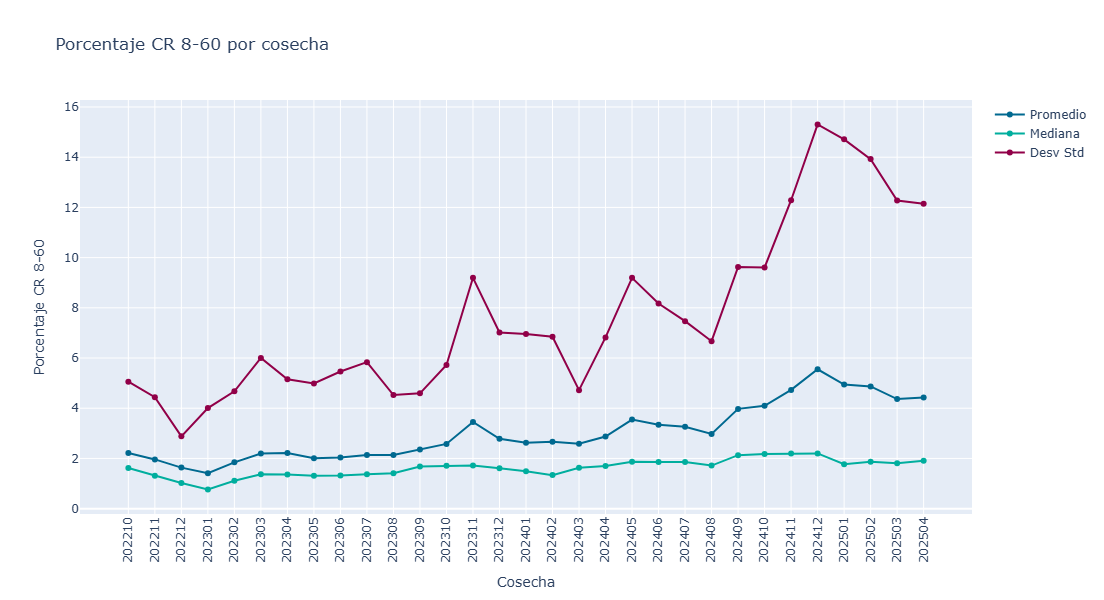

In [493]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=hist['COSECHA'], y=hist['promedio'], mode='lines+markers', name='Promedio', marker=dict(color='#006990')))

fig.add_trace(go.Scatter(x=hist['COSECHA'], y=hist['mediana'], mode='lines+markers', name='Mediana', marker=dict(color='#00AE9E')))

fig.add_trace(go.Scatter(x=hist['COSECHA'], y=hist['desvStd'], mode='lines+markers', name='Desv Std', marker=dict(color='#910048')))

fig.update_layout(
    title='Porcentaje CR 8-60 por cosecha',
    xaxis_title='Cosecha',
    yaxis_title='Porcentaje CR 8-60',
    xaxis_tickangle=-90,
    width=1000,
    height=600,
    showlegend=True
)

fig.show()

In [494]:
dfCarteraHist = pd.pivot_table(
    data=dfHist,
    columns='COSECHA',
    index='EMPLOYEE_ID',
    values = ['CARTERA_ASESOR','SINATRASO','CR1_7','CR8_8_60','CRMAS_60'],
    aggfunc={'CARTERA_ASESOR':'sum','SINATRASO':'sum','CR1_7':'sum','CR8_8_60':'sum','CRMAS_60':'sum'},
    fill_value=0
).reset_index()

In [495]:
dfCarteraHist.columns = ['_'.join(filter(None, col)).strip() for col in dfCarteraHist.columns.values]

In [496]:
# Nos quedamos con las columnas de la cartera en riesgo (8_60) y la cartera total
cr_cols = [col for col in dfCarteraHist.columns if col.startswith('CR8_8_60')]
cartera_cols = [col for col in dfCarteraHist.columns if col.startswith('CARTERA_ASESOR_')]

# Extraer los sufijos de fecha para hacer el cruce
fechas_cr = {col.split('_')[-1]: col for col in cr_cols}
fechas_cartera = {col.split('_')[-1]: col for col in cartera_cols}

# Generar los porcentajes de cartera en riesgo
for fecha in fechas_cr.keys() & fechas_cartera.keys():
    cr_col = fechas_cr[fecha]
    cartera_cols = fechas_cartera[fecha]
    dfCarteraHist[f'PORC_CR_{fecha}'] = (dfCarteraHist[cr_col] / dfCarteraHist[cartera_cols]).fillna(0)

dfCarteraHist.filter(like="PORC_CR").head()


,PORC_CR_202308,PORC_CR_202307,PORC_CR_202406,PORC_CR_202306,PORC_CR_202412,PORC_CR_202211,PORC_CR_202212,PORC_CR_202312,PORC_CR_202305,PORC_CR_202408,PORC_CR_202403,PORC_CR_202410,PORC_CR_202309,PORC_CR_202210,PORC_CR_202405,PORC_CR_202401,PORC_CR_202502,PORC_CR_202404,PORC_CR_202501,PORC_CR_202504,PORC_CR_202409,PORC_CR_202302,PORC_CR_202301,PORC_CR_202310,PORC_CR_202402,PORC_CR_202411,PORC_CR_202407,PORC_CR_202303,PORC_CR_202311,PORC_CR_202503,PORC_CR_202304
0,0.000000,0.000000,0.048167,0.000000,0.020897,0.000000,0.000000,0.095078,0.000000,0.043097,0.019886,0.033791,0.000000,0.000000,0.037748,0.057905,0.033106,0.048462,0.042283,0.014907,0.059170,0.00000,0.00000,0.000000,0.037075,0.018219,0.035683,0.000000,0.093738,0.046429,0.000000
1,0.031215,0.038341,0.004417,0.018998,0.034199,0.014316,0.010794,0.012253,0.007056,0.014648,0.015775,0.025734,0.022013,0.008982,0.009568,0.012256,0.020105,0.012630,0.026368,0.045279,0.018264,0.01904,0.00609,0.019124,0.028392,0.012228,0.016099,0.014126,0.013134,0.017913,0.014185
2,0.011171,0.009721,0.035281,0.008751,0.014247,0.000000,0.000000,0.008871,0.032748,0.007512,0.044069,0.031179,0.032898,0.000000,0.057707,0.008874,0.039546,0.048844,0.038766,0.031921,0.015268,0.00000,0.00000,0.000000,0.002753,0.005416,0.010843,0.000000,0.007835,0.031895,0.037630
3,0.000000,0.008831,0.042384,0.006392,0.022762,0.000000,0.000000,0.021694,0.045775,0.008708,0.043678,0.009430,0.018103,0.000000,0.044439,0.021694,0.034585,0.049262,0.015233,0.000000,0.010833,0.00000,0.00000,0.022890,0.016517,0.020934,0.019568,0.029797,0.028046,0.099913,0.074931
4,0.000000,0.000000,0.055058,0.000000,0.015462,0.000000,0.000000,0.030982,0.000000,0.043104,0.035271,0.019388,0.000000,0.000000,0.033588,0.030997,0.020454,0.036246,0.018956,0.013332,0.010020,0.00000,0.00000,0.000000,0.013959,0.021350,0.044113,0.000000,0.000000,0.018256,0.000000


In [497]:
dfHistAsesor = dfCarteraHist.filter(regex='EMPLOYEE_ID|PORC_CR').fillna(0)

In [498]:
dfHistAsesor.rename(columns={'EMPLOYEE_ID':'ASESOR_ID'}, inplace=True)

dfHistAsesor['y'] = dfHistAsesor[['PORC_CR_202501','PORC_CR_202502','PORC_CR_202503']].mean(axis=1)
dfHistAsesor.drop(columns=['PORC_CR_202501','PORC_CR_202502','PORC_CR_202503','PORC_CR_202504'], inplace=True)

## orden y renombramiento adecuado de columnas

In [499]:
def extraer_fecha(columna: str):
    if columna.startswith('PORC_CR_'):
        fecha = columna[8:]
        if len(fecha) == 6:
            year = int(fecha[:4])
            month = int(fecha[4:])
            return datetime(year, month, 1)
    return None

In [500]:
# diccionario para las columnas que contiene la fecha
columnas_fecha = {}
columnas_sin_fecha = []

for col in dfHistAsesor.columns:
    col_fecha = extraer_fecha(col)
    if col_fecha:
        columnas_fecha[col] = col_fecha
    else:
        columnas_sin_fecha.append(col)

In [501]:
cols_ordenadas = sorted(columnas_fecha.keys(), key=lambda x: columnas_fecha[x], reverse=True)

In [502]:
dict_renombrado = {}
prefijo = 'PORC_CR_T'
for i, col in enumerate(cols_ordenadas):
    nuevo_nombre = prefijo + str(i)
    dict_renombrado[col] = nuevo_nombre

In [503]:
dict_renombrado

{'PORC_CR_202504': 'PORC_CR_T0',
 'PORC_CR_202503': 'PORC_CR_T1',
 'PORC_CR_202502': 'PORC_CR_T2',
 'PORC_CR_202501': 'PORC_CR_T3',
 'PORC_CR_202412': 'PORC_CR_T4',
 'PORC_CR_202411': 'PORC_CR_T5',
 'PORC_CR_202410': 'PORC_CR_T6',
 'PORC_CR_202409': 'PORC_CR_T7',
 'PORC_CR_202408': 'PORC_CR_T8',
 'PORC_CR_202407': 'PORC_CR_T9',
 'PORC_CR_202406': 'PORC_CR_T10',
 'PORC_CR_202405': 'PORC_CR_T11',
 'PORC_CR_202404': 'PORC_CR_T12',
 'PORC_CR_202403': 'PORC_CR_T13',
 'PORC_CR_202402': 'PORC_CR_T14',
 'PORC_CR_202401': 'PORC_CR_T15',
 'PORC_CR_202312': 'PORC_CR_T16',
 'PORC_CR_202311': 'PORC_CR_T17',
 'PORC_CR_202310': 'PORC_CR_T18',
 'PORC_CR_202309': 'PORC_CR_T19',
 'PORC_CR_202308': 'PORC_CR_T20',
 'PORC_CR_202307': 'PORC_CR_T21',
 'PORC_CR_202306': 'PORC_CR_T22',
 'PORC_CR_202305': 'PORC_CR_T23',
 'PORC_CR_202304': 'PORC_CR_T24',
 'PORC_CR_202303': 'PORC_CR_T25',
 'PORC_CR_202302': 'PORC_CR_T26',
 'PORC_CR_202301': 'PORC_CR_T27',
 'PORC_CR_202212': 'PORC_CR_T28',
 'PORC_CR_202211': 'PORC

In [504]:
dfHistAsesor = dfHistAsesor.rename(columns=dict_renombrado)

In [505]:
# Union Asesor e histórico.
#dfHist:idAsesor, dfAsesor:asesorId
df = pd.merge(dfHistAsesor,dfAsesor, on='ASESOR_ID', how='inner')

In [506]:
dfHistAsesor.shape,df.shape,dfAsesor.shape

((2036, 32), (1773, 41), (2108, 10))

pd.pivot_table(
    data=df,
    index='POSITION_DESC',
    values='y',
    aggfunc=['min','max']
).reset_index()

In [507]:
# Solo aplicaríamos la estrategia al ASESOR, por lo que quitaremos los demás roles 
df.drop(df[df['POSITION_DESC']!='ASESOR CI'].index, axis=0, inplace=True)

In [508]:
df.groupby('POSITION_DESC')['ASESOR_ID'].count()

POSITION_DESC
ASESOR CI    1613
Name: ASESOR_ID, dtype: int64

In [ ]:
sns.displot(data=df, x='y', hue='POSITION_DESC', kind='kde', fill=True, palette='Set2', aspect=1.5)
plt.title('Distribución de la variable objetivo')
plt.show()

## Antiguedad asesor

In [509]:
df.ANT_ASESOR.describe()

count    1613.000000
mean       53.865468
std        52.106482
min         5.000000
25%        16.000000
50%        29.000000
75%        89.000000
max       302.000000
Name: ANT_ASESOR, dtype: float64

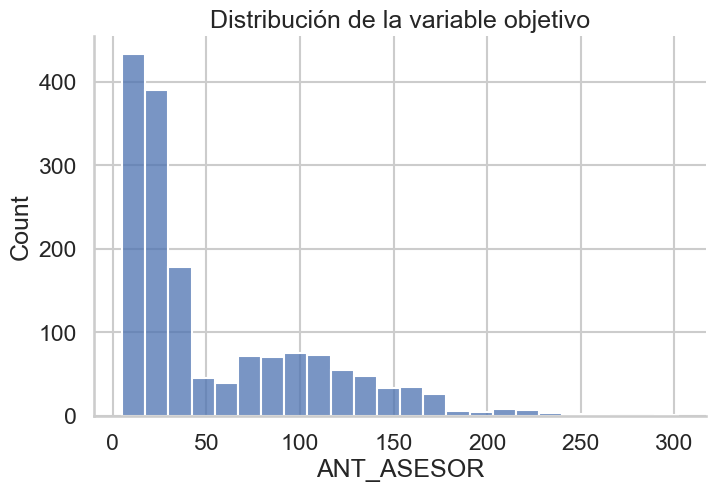

In [510]:
sns.displot(data=df, x='ANT_ASESOR', fill=True, palette='Set2', aspect=1.5)
plt.title('Distribución de la variable objetivo')
plt.show()

In [511]:
lsRangos = [-math.inf,3,6,9,12,24,36,math.inf]
lsEtiquetas = ["a.<=3","b.4-6","c.7-9","d.10-12","e.13-24","f.25-36","g.>=37"]
df['ANT_ASESOR_RANGO'] = pd.cut(df['ANT_ASESOR'], bins = lsRangos, labels = lsEtiquetas, right = True)

In [512]:
df['ANT_ASESOR_RANGO_NUM'] = df['ANT_ASESOR_RANGO'].cat.codes

In [513]:
df.groupby(['ANT_ASESOR_RANGO'])['ANT_ASESOR'].agg(['min','max','count'])

,min,max,count
ANT_ASESOR_RANGO,,,
a.<=3,NaN,NaN,0
b.4-6,5.0,6.0,63
c.7-9,7.0,9.0,132
d.10-12,10.0,12.0,114
e.13-24,13.0,24.0,389
f.25-36,25.0,36.0,241
g.>=37,37.0,302.0,674


**_Correlación de antigüedad con y_**

In [ ]:
coef_corr, p_value = pearsonr(df['ANT_ASESOR'], df['y'])
print(f'Correlación de Person: {coef_corr:.2f}, p-value:{p_value:.4f}')

In [ ]:
coef_corr_sper, p_value_spear = spearmanr(df['ANT_ASESOR_RANGO_NUM'], df['y'])
print(f'Correlación de Spearman: {coef_corr_sper:.2f}, p-value:{p_value_spear:.4f}')

**_ANOVA_**

In [ ]:
grupos_ant = [df[df['ANT_ASESOR_RANGO'] == cat]['y'] for cat in df['ANT_ASESOR_RANGO'].cat.categories]

# ANOVA para ver diferencias entre grupos de antiguedad
anova_result = stats.f_oneway(*grupos_ant)
print(f'ANOVA F-valor: {anova_result.statistic:.4f}, p-valor: {anova_result.pvalue:.4f}')

**_Conclusiones Rangos de antigüedad_**
- No existe correlación lineal con la variable objetivo
- Al realizar cortes a la antigüedad, tampoco se observa correlación de alguno de los cortes con la variable objetivo
- Se procedió a realizar una prueba estadíastica ANOVA para encontrar diferencias entre los grupos y la prueba nos indica que si tenemos diferencias, por lo que procedemos a realizar analis bivariados

In [ ]:
df['ANT_ASESOR_RANGO'] = df['ANT_ASESOR_RANGO'].astype('category')
df['ANT_ASESOR_RANGO_NUM'] = df['ANT_ASESOR_RANGO_NUM'].astype('category')

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='ANT_ASESOR_RANGO', y='HORAS_VUELO', palette='Set2')
plt.title('Distribución de HORAS_VUELO por Antigüedad del Asesor')
plt.xlabel('Rango de Antigüedad del Asesor')
plt.ylabel('Horas de Vuelo')
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='ANT_ASESOR_RANGO', y='PORC_CR_T0', palette='Set2')
plt.title('Distribución de CR 8a60 T0 por Antigüedad del Asesor')
plt.xlabel('Rango de Antigüedad del Asesor')
plt.ylabel('Cr 8a60 T0')
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='ANT_ASESOR_RANGO', y='PORC_CR_T1', palette='Set2')
plt.title('Distribución de CR 8a60 T1 por Antigüedad del Asesor')
plt.xlabel('Rango de Antigüedad del Asesor')
plt.ylabel('Cr 8a60 T1')
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='ANT_ASESOR_RANGO', y='PORC_CR_T2', palette='Set2')
plt.title('Distribución de CR 8a60 T2 por Antigüedad del Asesor')
plt.xlabel('Rango de Antigüedad del Asesor')
plt.ylabel('Cr 8a60 T2')
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='ANT_ASESOR_RANGO', y='PORCT_RENOV_T0', palette='Set2')
plt.title('Distribución de Renovacion T0 por Antigüedad del Asesor')
plt.xlabel('Rango de Antigüedad del Asesor')
plt.ylabel('Porc renovacion T0')
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**_Nos quedamos solo  con asesores de 4+ meses de antigüedad_**

In [514]:
df.drop(df[df.ANT_ASESOR_RANGO=='a.<=3'].index, axis = 0, inplace = True)

In [515]:
df.shape

(1613, 43)

# Base por contratos

In [516]:
dfCliente.rename(columns = {'ADVISOR_ID':'ASESOR_ID'}, inplace=True)

In [517]:
dfCliente.shape

(836194, 32)

In [518]:
dfCliente.FECHA_CORTE.value_counts()

FECHA_CORTE
2025-04-30    287631
2025-03-31    279295
2025-02-28    269268
Name: count, dtype: int64

In [519]:
dfT0 = dfCliente[dfCliente.FECHA_CORTE=='2024-12-31']

In [520]:
dfT0[dfT0.ASESOR_ID==86176238].shape

(0, 32)

***_Flags_***

In [521]:
def add_column(df, col_name):
    """
    Decorador para agregar una nueva columna a un DataFrame.
    La función decorada debe devolver una Serie que será asignada como la nueva columna.
    """
    def decorator(func):
        def wrapper(*args, **kwargs):
            print(f"Agregando columna: {col_name}") 
            df[col_name] = func(*args, **kwargs)
        return wrapper
    return decorator

In [522]:
@add_column(dfCliente, 'FLAG_NUEVOS_PUROS')
def calculate_flag_nuevos_puros(df):
    return (df['CICLOS_EJE'] == 1).astype(int)

@add_column(dfCliente, 'FLAG_NUEVOS_PRODUCTO')
def calculate_flag_nuevos_producto(df):
    return (df['CICLO_CI'] == 1).astype(int)

@add_column(dfCliente, 'FLAG_SEGURO_VOLUNTARIO')
def calculate_flag_seguro_voluntario(df):
    return df['MODALIDAD'].isin([1, 2]).astype(int)

@add_column(dfCliente, 'FLAG_SEGURO_FAMILIAR')
def calculate_flag_seguro_familiar(df):
    return (df['MODALIDAD'] == 1).astype(int)

@add_column(dfCliente, 'COSECHA')
def calculate_cosecha(df):
    return df['CONTRACT_START_DT'].apply(generaCosecha)

@add_column(dfCliente, 'MES_CORTE')
def calculate_mes_corte(df):
    return df['FECHA_CORTE'].apply(generaCosecha)

@add_column(dfCliente, 'MES_FIN')
def calculate_mes_fin(df):
    return df['CONTRACT_END_DT'].apply(generaCosecha)

@add_column(dfCliente, 'FLAG_COLOCACION_MES')
def calculate_flag_colocacion_mes(df):
    return (df['COSECHA'] == df['MES_CORTE']).astype(int)

@add_column(dfCliente, 'FLAG_SIN_CARTERA')
def calculate_flag_sin_cartera(df):
    return df['MONTO_CARTERA'].isnull().astype(int)

@add_column(dfCliente, 'FLAG_NUEVOS_PUROS_MES')
def flag_nuevos_puros_mes(df):
    return ((df['FLAG_NUEVOS_PUROS'] == 1) & (df['FLAG_COLOCACION_MES'] == 1)).astype(int)

@add_column(dfCliente, 'FLAG_NUEVOS_PRODUCTO_MES')
def flag_nuevos_producto_mes(df):
    return ((df['FLAG_NUEVOS_PRODUCTO'] == 1) & (df['FLAG_COLOCACION_MES'] == 1)).astype(int)

@add_column(dfCliente, 'FLAG_EXPERIENCIA_CI')
def flag_experiencia_ci(df):
    return ((df['FLAG_NUEVOS_PRODUCTO'] == 1) & (df['MES_CORTE'] == df['COSECHA'])).astype(int)

@add_column(dfCliente, 'BUCKET_ATRASO_ACTUAL')
def calculate_bucket_atraso_actual(df):
    ls_limites = [-math.inf, 1, 8, 60, math.inf]
    ls_etiquetas = ['a.CR0', 'b.CR1a7', 'd.CR8a60', 'e.CR60+']
    return pd.cut(df['DIAS_ATRASO_ACTUAL'], bins=ls_limites, labels=ls_etiquetas, right=False)

@add_column(dfCliente, 'BUCKET_ATRASO_ANTERIOR')
def calculate_bucket_atraso_ant(df):
    ls_limites = [-math.inf, 1, 8, 60, math.inf]
    ls_etiquetas = ['a.CR0', 'b.CR1a7', 'd.CR8a60', 'e.CR60+']
    return pd.cut(df['DIAS_ATRASO_MES_ANT'], bins=ls_limites, labels=ls_etiquetas, right=False)

@add_column(dfCliente, 'FLAG_DESEMBOLSO_TDD')
def flag_desembolso_tdd(df):
    return (df['ID_METODO_DISPERSION'] == 3).astype(int)

# Para la columna 'flag_experiencia_grupal'
@add_column(dfCliente, 'FLAG_EXPERIENCIA_GRUPAL')
def flag_experiencia_grupal(df):
    return (df['CICLOS_TOTAL_GRUPAL'] > 0).astype(int)

# Para la columna 'flag_experiencia'
@add_column(dfCliente, 'FLAG_EXPERIENCIA')
def flag_experiencia(df):
    return (df['CICLO_CI'] > 3).astype(int)

@add_column(dfCliente, 'RANGO_CICLO_CI')
def calculate_rango_cicloCI(df):
    ls_limitesCi = [-math.inf,2, 3, 4, 5, 6, 7 ,math.inf]
    ls_etiquetasCi = ['a.1', 'b.2', 'c.3', 'd.4', 'e.5', 'f.6','g.7+']
    return pd.cut(df['CICLO_CI'], bins = ls_limitesCi, labels = ls_etiquetasCi, right = False)

In [523]:
calculate_flag_nuevos_puros(dfCliente)
calculate_flag_nuevos_producto(dfCliente)
calculate_flag_seguro_voluntario(dfCliente)
calculate_flag_seguro_familiar(dfCliente)
calculate_cosecha(dfCliente)
calculate_mes_corte(dfCliente)
calculate_mes_fin(dfCliente)
calculate_flag_colocacion_mes(dfCliente)
calculate_flag_sin_cartera(dfCliente)
flag_nuevos_puros_mes(dfCliente)
flag_nuevos_producto_mes(dfCliente)
flag_experiencia_ci(dfCliente)
calculate_bucket_atraso_actual(dfCliente)
calculate_bucket_atraso_ant(dfCliente)
flag_desembolso_tdd(dfCliente)
flag_experiencia_grupal(dfCliente)
flag_experiencia(dfCliente)
calculate_rango_cicloCI(dfCliente)

Agregando columna: FLAG_NUEVOS_PUROS
Agregando columna: FLAG_NUEVOS_PRODUCTO
Agregando columna: FLAG_SEGURO_VOLUNTARIO
Agregando columna: FLAG_SEGURO_FAMILIAR
Agregando columna: COSECHA
Agregando columna: MES_CORTE
Agregando columna: MES_FIN
Agregando columna: FLAG_COLOCACION_MES
Agregando columna: FLAG_SIN_CARTERA
Agregando columna: FLAG_NUEVOS_PUROS_MES
Agregando columna: FLAG_NUEVOS_PRODUCTO_MES
Agregando columna: FLAG_EXPERIENCIA_CI
Agregando columna: BUCKET_ATRASO_ACTUAL
Agregando columna: BUCKET_ATRASO_ANTERIOR
Agregando columna: FLAG_DESEMBOLSO_TDD
Agregando columna: FLAG_EXPERIENCIA_GRUPAL
Agregando columna: FLAG_EXPERIENCIA
Agregando columna: RANGO_CICLO_CI


In [524]:
dfCliente.head()

,CONTRACT_ID,CUSTOMER_ID,LOAN_CAPITAL_AMT,ASESOR_ID,CONTRACT_STATUS_CD,CICLO_CI,CICLOS_TOTAL_GRUPAL,CICLOS_EJE,EDAD,GENDER_CD,TIME_BUSINESS_CD,TIME_BUSINESS_DESC,ECONOMIC_SECTOR_ACTIVITY_CD,MODALIDAD,ID_METODO_DISPERSION,DISBMNT_AMT,CUSTOMER_ORIG_ID,CONTRACT_START_DT,CONTRACT_END_DT,MONTO_CARTERA,DIAS_ATRASO_ACTUAL,FECHA_CORTE,FLAG_TR,TR,FLAG_VC,FLAG_MAC,FLAG_AMI,FLAG_FPD,DIAS_ATRASO_MES_ANT,MONTO_CARTERA_ANT,ASESOR_ORIGINADOR,FLAG_ORIGINADOR,FLAG_NUEVOS_PUROS,FLAG_NUEVOS_PRODUCTO,FLAG_SEGURO_VOLUNTARIO,FLAG_SEGURO_FAMILIAR,COSECHA,MES_CORTE,MES_FIN,FLAG_COLOCACION_MES,FLAG_SIN_CARTERA,FLAG_NUEVOS_PUROS_MES,FLAG_NUEVOS_PRODUCTO_MES,FLAG_EXPERIENCIA_CI,BUCKET_ATRASO_ACTUAL,BUCKET_ATRASO_ANTERIOR,FLAG_DESEMBOLSO_TDD,FLAG_EXPERIENCIA_GRUPAL,FLAG_EXPERIENCIA,RANGO_CICLO_CI
0,140033254,15086,54314.18,8864775,1,2,1,3,44,2,2,MENOS DE 6 MESES,30,0,3.0,50011.17,200033,2025-04-15,2026-11-15,54314.18,0,2025-04-30,1,None,0,1,0,-1,NaN,NaN,NaN,0,0,0,0,0,202504,202504,202611,1,0,0,0,0,a.CR0,NaN,1,1,0,b.2
1,129623178,15086,32399.75,8864775,1,1,1,2,44,2,2,MENOS DE 6 MESES,30,1,1.0,30004.75,200033,2024-04-30,2025-08-03,14203.23,0,2025-03-31,1,None,0,1,0,0,0.0,16560.66,8864775.0,0,0,1,1,1,202404,202503,202508,0,0,0,0,0,a.CR0,a.CR0,0,1,0,a.1
2,129623178,15086,32399.75,8864775,1,1,1,2,44,2,2,MENOS DE 6 MESES,30,1,1.0,30004.75,200033,2024-04-30,2025-08-03,16560.66,0,2025-02-28,1,None,0,1,0,0,0.0,18778.73,8864775.0,0,0,1,1,1,202404,202502,202508,0,0,0,0,0,a.CR0,a.CR0,0,1,0,a.1
3,138315113,15465,30076.11,44796482,1,20,0,20,53,2,5,MAS DE 2 Y HASTA 3 AÑOS,28,0,3.0,30004.11,3505022,2025-02-24,2026-02-06,28351.92,0,2025-03-31,1,None,1,1,0,0,0.0,30076.11,NaN,0,0,0,0,0,202502,202503,202602,0,0,0,0,0,a.CR0,a.CR0,1,0,1,g.7+
4,138315113,15465,30076.11,1951589,1,20,0,20,53,2,5,MAS DE 2 Y HASTA 3 AÑOS,28,0,3.0,30004.11,3505022,2025-02-24,2026-02-06,30076.11,0,2025-02-28,1,None,1,1,0,0,NaN,NaN,NaN,0,0,0,0,0,202502,202502,202602,1,0,0,0,0,a.CR0,NaN,1,0,1,g.7+


***_First Payment Default_***

In [525]:
dfCliente.FLAG_FPD.value_counts()
# El valor -1 para FPD, significa que aun no ha realizado pagos y no se puede definir si caerá o no en FPD

FLAG_FPD
 0    702445
 1     89905
-1     43844
Name: count, dtype: int64

In [526]:
ls_fpd = ['ASESOR_ID','FPD_INDEF_T2','FPD0_INDEF_T1','FPD0_INDEF_T0','FPD0_T2',
          'FPD0_T1','FPD0_T0','FPD1_T2','FPD1_T1','FPD1_T0'
         ]

In [527]:
dfFPD = pd.pivot_table(data=dfCliente,
               columns=['FLAG_FPD','MES_CORTE'],
               index='ASESOR_ID',
               values = 'CONTRACT_ID',
               aggfunc='count',
               fill_value=0
              ).reset_index()

dfFPD.columns = ls_fpd
dfFPD.drop(columns=['FPD_INDEF_T2','FPD0_INDEF_T1','FPD0_INDEF_T0'], inplace=True)
dfFPD.head()

,ASESOR_ID,FPD0_T2,FPD0_T1,FPD0_T0,FPD1_T2,FPD1_T1,FPD1_T0
0,1949827,108,101,88,18,18,14
1,1949838,215,227,149,17,17,10
2,1949853,137,133,122,3,1,1
3,1950569,147,138,145,22,22,19
4,1950587,155,135,130,27,25,23


In [528]:
dfFPD['PCNT_FPD_T2'] = dfFPD['FPD1_T2']/(dfFPD[['FPD1_T2','FPD0_T2']].sum(axis=1))
dfFPD['PCNT_FPD_T1'] = dfFPD['FPD1_T1']/(dfFPD[['FPD1_T1','FPD0_T1']].sum(axis=1))
dfFPD['PCNT_FPD_T0'] = dfFPD['FPD1_T0']/(dfFPD[['FPD1_T0','FPD0_T0']].sum(axis=1))
dfFPD.drop(columns=['FPD0_T2','FPD0_T1','FPD0_T0','FPD1_T2','FPD1_T1','FPD1_T0'], inplace=True)

In [529]:
dfFPD.fillna(0, inplace=True)
dfFPD.head()

,ASESOR_ID,PCNT_FPD_T2,PCNT_FPD_T1,PCNT_FPD_T0
0,1949827,0.142857,0.151261,0.137255
1,1949838,0.073276,0.069672,0.062893
2,1949853,0.021429,0.007463,0.008130
3,1950569,0.130178,0.137500,0.115854
4,1950587,0.148352,0.156250,0.150327


In [530]:
dfFPD.isnull().sum()

ASESOR_ID      0
PCNT_FPD_T2    0
PCNT_FPD_T1    0
PCNT_FPD_T0    0
dtype: int64

***_Tenencia Ctas captacion_***

In [531]:
ls_ctas = ['ASESOR_ID','TOT_AMI_T2','TOT_AMI_T1','TOT_AMI_T0','TOT_MAC_T2','TOT_MAC_T1','TOT_MAC_T0']

In [532]:
dfCapta = pd.pivot_table(data=dfCliente,
         index='ASESOR_ID',
         columns=['MES_CORTE'],
         values = ['FLAG_MAC','FLAG_AMI'],
         aggfunc={'FLAG_MAC':'sum', 'FLAG_AMI':'sum'},
         fill_value=0
        ).reset_index()

dfCapta.columns = ls_ctas
dfCapta.head()

,ASESOR_ID,TOT_AMI_T2,TOT_AMI_T1,TOT_AMI_T0,TOT_MAC_T2,TOT_MAC_T1,TOT_MAC_T0
0,1949827,2,2,3,126,130,130
1,1949838,1,1,1,232,249,167
2,1949853,8,6,6,139,135,140
3,1950569,0,0,0,168,169,185
4,1950587,0,0,0,41,34,37


***_Tenencia VC_***

In [533]:
ls_vc = ['ASESOR_ID','TOT_SINVC_T2','TOT_SINVC_T1','TOT_SINVC_T0','TOT_VC_T2','TOT_VC_T1','TOT_VC_T0']

In [534]:
dfCliente['FLAG_VC'] = dfCliente.FLAG_VC.apply(lambda row: 1 if row > 0 else 0)
dfVC = pd.pivot_table(data=dfCliente,
               index='ASESOR_ID',
               columns=['FLAG_VC','MES_CORTE'],
               values = 'CONTRACT_ID',
               aggfunc='count'
              ).reset_index()

dfVC.columns = ls_vc
dfVC.head()

,ASESOR_ID,TOT_SINVC_T2,TOT_SINVC_T1,TOT_SINVC_T0,TOT_VC_T2,TOT_VC_T1,TOT_VC_T0
0,1949827,121.0,123.0,123.0,5.0,7.0,7.0
1,1949838,163.0,180.0,120.0,69.0,69.0,47.0
2,1949853,113.0,108.0,109.0,27.0,28.0,32.0
3,1950569,92.0,90.0,97.0,78.0,81.0,90.0
4,1950587,161.0,144.0,148.0,21.0,19.0,20.0


***_colocacion por mes_***: No. de créditos colocados en los últimos 3 meses

In [535]:
ls_colocacion = ['ASESOR_ID','DESEMBOLSOS_SIN_EXP_T2','DESEMBOLSOS_CON_EXP_T2','DESEMBOLSOS_SIN_EXP_T1','DESEMBOLSOS_CON_EXP_T1',
                 'DESEMBOLSOS_SIN_EXP_T0','DESEMBOLSOS_CON_EXP_T0']

In [536]:
dfColocacion = pd.pivot_table(data=dfCliente,
               index='ASESOR_ID',
               columns=['MES_CORTE', 'FLAG_EXPERIENCIA'],
               values='FLAG_COLOCACION_MES',
               aggfunc='sum',
               fill_value=0
              ).reset_index()

dfColocacion.columns = ls_colocacion
dfColocacion.head()

,ASESOR_ID,DESEMBOLSOS_SIN_EXP_T2,DESEMBOLSOS_CON_EXP_T2,DESEMBOLSOS_SIN_EXP_T1,DESEMBOLSOS_CON_EXP_T1,DESEMBOLSOS_SIN_EXP_T0,DESEMBOLSOS_CON_EXP_T0
0,1949827,12,1,13,3,13,4
1,1949838,11,6,5,7,2,2
2,1949853,9,0,11,2,12,4
3,1950569,13,5,13,7,8,5
4,1950587,9,1,6,8,6,6


***_Monto cartera_***: No. de créditos colocados en los últimos 3 meses

In [537]:
columnsMetricas = ['ASESOR_ID',
        'AVG_CICLOS_EJE_T2','AVG_CICLOS_EJE_T1','AVG_CICLOS_EJE_T0',
        'AVG_CICLOS_CI_T2','AVG_CICLOS_CI_T1','AVG_CICLOS_CI_T0',
        'CLIENTES_T2','CLIENTES_T1','CLIENTES_T0',
        'CLIENTES_EXPERIENCIA_GRUPAL_T2','CLIENTES_EXPERIENCIA_GRUPAL_T1','CLIENTES_EXPERIENCIA_GRUPAL_T0',
        'NUEVOS_PRODUCTO_T2','NUEVOS_PRODUCTO_T1','NUEVOS_PRODUCTO_T0',
        'NUEVOS_PUROS_T2','NUEVOS_PUROS_T1','NUEVOS_PUROS_T0',
        'SEGURO_FAMILIAR_T2', 'SEGURO_FAMILIAR_T1', 'SEGURO_FAMILIAR_T0',
        'SEGURO_VOLUNTARIO_T2', 'SEGURO_VOLUNTARIO_T1', 'SEGURO_VOLUNTARIO_T0',
        'MONTO_CARTERA_T2','MONTO_CARTERA_T1','MONTO_CARTERA_T0' #cartera actual o monto desembolsado
        ]

ls_values=['MONTO_CARTERA','CONTRACT_ID','FLAG_NUEVOS_PUROS_MES','FLAG_NUEVOS_PRODUCTO_MES','FLAG_SEGURO_VOLUNTARIO',
        'FLAG_SEGURO_FAMILIAR','CICLO_CI','CICLOS_EJE','FLAG_EXPERIENCIA_GRUPAL']

dict_agg = {'MONTO_CARTERA': 'sum', 'CONTRACT_ID': 'count','FLAG_NUEVOS_PUROS_MES':'sum','FLAG_NUEVOS_PRODUCTO_MES':'sum',
 'FLAG_SEGURO_VOLUNTARIO':'sum', 'FLAG_SEGURO_FAMILIAR':'sum','CICLO_CI':['mean'],
            'CICLOS_EJE':['mean'], 
            'FLAG_EXPERIENCIA_GRUPAL':'sum'}

In [538]:
dfMetricas = pd.pivot_table(data = dfCliente,
               index = 'ASESOR_ID',
               columns = 'MES_CORTE',
               values = ls_values,
               aggfunc = dict_agg,
               fill_value = 0).reset_index()

dfMetricas.columns = columnsMetricas
dfMetricas.head()

,ASESOR_ID,AVG_CICLOS_EJE_T2,AVG_CICLOS_EJE_T1,AVG_CICLOS_EJE_T0,AVG_CICLOS_CI_T2,AVG_CICLOS_CI_T1,AVG_CICLOS_CI_T0,CLIENTES_T2,CLIENTES_T1,CLIENTES_T0,CLIENTES_EXPERIENCIA_GRUPAL_T2,CLIENTES_EXPERIENCIA_GRUPAL_T1,CLIENTES_EXPERIENCIA_GRUPAL_T0,NUEVOS_PRODUCTO_T2,NUEVOS_PRODUCTO_T1,NUEVOS_PRODUCTO_T0,NUEVOS_PUROS_T2,NUEVOS_PUROS_T1,NUEVOS_PUROS_T0,SEGURO_FAMILIAR_T2,SEGURO_FAMILIAR_T1,SEGURO_FAMILIAR_T0,SEGURO_VOLUNTARIO_T2,SEGURO_VOLUNTARIO_T1,SEGURO_VOLUNTARIO_T0,MONTO_CARTERA_T2,MONTO_CARTERA_T1,MONTO_CARTERA_T0
0,1949827,4.706349,5.307692,5.330769,2.269841,2.346154,2.430769,126,130,130,27,30,28,3,6,4,3,3,3,79,68,52,81,70,54,6178227.31,6915660.59,6873717.75
1,1949838,8.892241,9.257028,8.886228,3.469828,3.851406,3.946108,232,249,167,97,106,69,5,1,1,2,1,1,96,96,59,152,140,85,9342057.97,9627680.15,6414147.94
2,1949853,8.721429,8.617647,9.418440,3.028571,3.095588,3.156028,140,136,141,68,66,70,3,4,4,1,3,2,103,87,75,103,87,75,6754217.46,6602618.82,7157713.26
3,1950569,7.023529,7.321637,7.556150,4.005882,4.081871,4.106952,170,171,187,50,53,58,7,5,2,6,3,2,50,51,58,50,51,58,10879989.57,11822732.61,12793087.78
4,1950587,11.703297,11.932515,12.202381,4.494505,4.625767,4.690476,182,163,168,105,96,98,5,3,3,4,1,1,126,105,106,135,110,109,6353854.02,5575795.02,5813115.02


In [539]:
dfMetricas.isnull().sum()

ASESOR_ID                         0
AVG_CICLOS_EJE_T2                 0
AVG_CICLOS_EJE_T1                 0
AVG_CICLOS_EJE_T0                 0
AVG_CICLOS_CI_T2                  0
AVG_CICLOS_CI_T1                  0
AVG_CICLOS_CI_T0                  0
CLIENTES_T2                       0
CLIENTES_T1                       0
CLIENTES_T0                       0
CLIENTES_EXPERIENCIA_GRUPAL_T2    0
CLIENTES_EXPERIENCIA_GRUPAL_T1    0
CLIENTES_EXPERIENCIA_GRUPAL_T0    0
NUEVOS_PRODUCTO_T2                0
NUEVOS_PRODUCTO_T1                0
NUEVOS_PRODUCTO_T0                0
NUEVOS_PUROS_T2                   0
NUEVOS_PUROS_T1                   0
NUEVOS_PUROS_T0                   0
SEGURO_FAMILIAR_T2                0
SEGURO_FAMILIAR_T1                0
SEGURO_FAMILIAR_T0                0
SEGURO_VOLUNTARIO_T2              0
SEGURO_VOLUNTARIO_T1              0
SEGURO_VOLUNTARIO_T0              0
MONTO_CARTERA_T2                  0
MONTO_CARTERA_T1                  0
MONTO_CARTERA_T0            

***_Calidad de Cartera_***: con / sin experiencia

In [540]:
ls_Calidad = ['ASESOR_ID',
'CTES0_SIN_EXP_T2', 'CTES0_CON_EXP_T2','CTES1A7_SIN_EXP_T2', 'CTES1A7_CON_EXP_T2','CTES8A60_SIN_EXP_T2','CTES8A60_CON_EXP_T2',
'CTES60M_SIN_EXP_T2','CTES60M_CON_EXP_T2',
'CTES0_SIN_EXP_T1', 'CTES0_CON_EXP_T1','CTES1A7_SIN_EXP_T1', 'CTES1A7_CON_EXP_T1','CTES8A60_SIN_EXP_T1','CTES8A60_CON_EXP_T1',
'CTES60M_SIN_EXP_T1','CTES60M_CON_EXP_T1',
'CTES0_SIN_EXP_T0', 'CTES0_CON_EXP_T0','CTES1A7_SIN_EXP_T0', 'CTES1A7_CON_EXP_T0','CTES8A60_SIN_EXP_T0','CTES8A60_CON_EXP_T0',
'CTES60M_SIN_EXP_T0','CTES60M_CON_EXP_T0',
'CR0_SIN_EXP_T2', 'CR0_CON_EXP_T2','CR1A7_SIN_EXP_T2', 'CR1A7_CON_EXP_T2','CR8A60_SIN_EXP_T2','CR8A60_CON_EXP_T2',
'CR60M_SIN_EXP_T2','CR60M_CON_EXP_T2',
'CR0_SIN_EXP_T1', 'CR0_CON_EXP_T1','CR1A7_SIN_EXP_T1', 'CR1A7_CON_EXP_T1','CR8A60_SIN_EXP_T1','CR8A60_CON_EXP_T1',
'CR60M_SIN_EXP_T1','CR60M_CON_EXP_T1',
'CR0_SIN_EXP_T0', 'CR0_CON_EXP_T0','CR1A7_SIN_EXP_T0', 'CR1A7_CON_EXP_T0','CR8A60_SIN_EXP_T0','CR8A60_CON_EXP_T0',
'CR60M_SIN_EXP_T0','CR60M_CON_EXP_T0'
]

dfCalidad = pd.pivot_table(
    data=dfCliente,
    index='ASESOR_ID',
    columns=['MES_CORTE','BUCKET_ATRASO_ACTUAL','FLAG_EXPERIENCIA'],
    values = ['CONTRACT_ID','MONTO_CARTERA'],
    aggfunc={'CONTRACT_ID':'count', 'MONTO_CARTERA':'sum'}
).reset_index()

dfCalidad.columns = ls_Calidad

dfCalidad.head()

,ASESOR_ID,CTES0_SIN_EXP_T2,CTES0_CON_EXP_T2,CTES1A7_SIN_EXP_T2,CTES1A7_CON_EXP_T2,CTES8A60_SIN_EXP_T2,CTES8A60_CON_EXP_T2,CTES60M_SIN_EXP_T2,CTES60M_CON_EXP_T2,CTES0_SIN_EXP_T1,CTES0_CON_EXP_T1,CTES1A7_SIN_EXP_T1,CTES1A7_CON_EXP_T1,CTES8A60_SIN_EXP_T1,CTES8A60_CON_EXP_T1,CTES60M_SIN_EXP_T1,CTES60M_CON_EXP_T1,CTES0_SIN_EXP_T0,CTES0_CON_EXP_T0,CTES1A7_SIN_EXP_T0,CTES1A7_CON_EXP_T0,CTES8A60_SIN_EXP_T0,CTES8A60_CON_EXP_T0,CTES60M_SIN_EXP_T0,CTES60M_CON_EXP_T0,CR0_SIN_EXP_T2,CR0_CON_EXP_T2,CR1A7_SIN_EXP_T2,CR1A7_CON_EXP_T2,CR8A60_SIN_EXP_T2,CR8A60_CON_EXP_T2,CR60M_SIN_EXP_T2,CR60M_CON_EXP_T2,CR0_SIN_EXP_T1,CR0_CON_EXP_T1,CR1A7_SIN_EXP_T1,CR1A7_CON_EXP_T1,CR8A60_SIN_EXP_T1,CR8A60_CON_EXP_T1,CR60M_SIN_EXP_T1,CR60M_CON_EXP_T1,CR0_SIN_EXP_T0,CR0_CON_EXP_T0,CR1A7_SIN_EXP_T0,CR1A7_CON_EXP_T0,CR8A60_SIN_EXP_T0,CR8A60_CON_EXP_T0,CR60M_SIN_EXP_T0,CR60M_CON_EXP_T0
0,1949827,108,14,0,0,3,1,0,0,106,14,0,0,8,2,0,0,109,15,0,0,6,0,0,0,4648576.31,1325116.39,0.00,0.00,184632.25,19902.36,0.00,0.0,5093836.26,1500735.00,0.00,0.00,289462.08,31627.25,0.00,0.0,5259009.85,1512238.80,0.00,0.00,102469.10,0.00,0.0,0.0
1,1949838,161,63,1,1,6,0,0,0,158,82,1,2,5,1,0,0,98,56,1,0,10,2,0,0,5668321.97,3442983.63,18635.21,24293.06,187824.10,0.00,0.00,0.0,5243745.94,4171810.08,15937.02,23721.72,147135.56,25329.83,0.00,0.0,3395122.60,2707990.74,20607.10,0.00,263182.01,27245.49,0.0,0.0
2,1949853,108,26,0,0,5,1,0,0,105,27,0,0,2,2,0,0,107,28,1,0,3,2,0,0,4904831.70,1582283.96,0.00,0.00,197195.75,69906.05,0.00,0.0,4834649.29,1557379.92,0.00,0.00,87637.13,122952.48,0.00,0.0,5048708.95,1857308.57,23211.53,0.00,119906.10,108578.11,0.0,0.0
3,1950569,110,53,0,0,6,1,0,0,109,54,0,0,5,3,0,0,118,62,0,0,4,3,0,0,7063967.95,3593484.47,0.00,0.00,201534.62,21002.53,0.00,0.0,7825044.51,3781848.74,0.00,0.00,145237.42,70601.94,0.00,0.0,8593025.57,4029502.13,0.00,0.00,69396.74,101163.34,0.0,0.0
4,1950587,101,68,6,2,3,0,2,0,83,64,7,2,5,1,1,0,83,64,6,5,9,1,0,0,2881801.62,3221230.42,113426.10,38162.11,45942.88,0.00,53290.89,0.0,2399215.61,2896657.45,123864.27,72259.18,65661.55,15673.54,2463.42,0.0,2476558.61,2892092.44,76154.76,159836.61,192799.06,15673.54,0.0,0.0


In [541]:
dfMetricas[dfMetricas['ASESOR_ID']==1949827]

,ASESOR_ID,AVG_CICLOS_EJE_T2,AVG_CICLOS_EJE_T1,AVG_CICLOS_EJE_T0,AVG_CICLOS_CI_T2,AVG_CICLOS_CI_T1,AVG_CICLOS_CI_T0,CLIENTES_T2,CLIENTES_T1,CLIENTES_T0,CLIENTES_EXPERIENCIA_GRUPAL_T2,CLIENTES_EXPERIENCIA_GRUPAL_T1,CLIENTES_EXPERIENCIA_GRUPAL_T0,NUEVOS_PRODUCTO_T2,NUEVOS_PRODUCTO_T1,NUEVOS_PRODUCTO_T0,NUEVOS_PUROS_T2,NUEVOS_PUROS_T1,NUEVOS_PUROS_T0,SEGURO_FAMILIAR_T2,SEGURO_FAMILIAR_T1,SEGURO_FAMILIAR_T0,SEGURO_VOLUNTARIO_T2,SEGURO_VOLUNTARIO_T1,SEGURO_VOLUNTARIO_T0,MONTO_CARTERA_T2,MONTO_CARTERA_T1,MONTO_CARTERA_T0
0,1949827,4.706349,5.307692,5.330769,2.269841,2.346154,2.430769,126,130,130,27,30,28,3,6,4,3,3,3,79,68,52,81,70,54,6178227.31,6915660.59,6873717.75


In [542]:
dfCalidad[dfCalidad['ASESOR_ID']==1949827]

,ASESOR_ID,CTES0_SIN_EXP_T2,CTES0_CON_EXP_T2,CTES1A7_SIN_EXP_T2,CTES1A7_CON_EXP_T2,CTES8A60_SIN_EXP_T2,CTES8A60_CON_EXP_T2,CTES60M_SIN_EXP_T2,CTES60M_CON_EXP_T2,CTES0_SIN_EXP_T1,CTES0_CON_EXP_T1,CTES1A7_SIN_EXP_T1,CTES1A7_CON_EXP_T1,CTES8A60_SIN_EXP_T1,CTES8A60_CON_EXP_T1,CTES60M_SIN_EXP_T1,CTES60M_CON_EXP_T1,CTES0_SIN_EXP_T0,CTES0_CON_EXP_T0,CTES1A7_SIN_EXP_T0,CTES1A7_CON_EXP_T0,CTES8A60_SIN_EXP_T0,CTES8A60_CON_EXP_T0,CTES60M_SIN_EXP_T0,CTES60M_CON_EXP_T0,CR0_SIN_EXP_T2,CR0_CON_EXP_T2,CR1A7_SIN_EXP_T2,CR1A7_CON_EXP_T2,CR8A60_SIN_EXP_T2,CR8A60_CON_EXP_T2,CR60M_SIN_EXP_T2,CR60M_CON_EXP_T2,CR0_SIN_EXP_T1,CR0_CON_EXP_T1,CR1A7_SIN_EXP_T1,CR1A7_CON_EXP_T1,CR8A60_SIN_EXP_T1,CR8A60_CON_EXP_T1,CR60M_SIN_EXP_T1,CR60M_CON_EXP_T1,CR0_SIN_EXP_T0,CR0_CON_EXP_T0,CR1A7_SIN_EXP_T0,CR1A7_CON_EXP_T0,CR8A60_SIN_EXP_T0,CR8A60_CON_EXP_T0,CR60M_SIN_EXP_T0,CR60M_CON_EXP_T0
0,1949827,108,14,0,0,3,1,0,0,106,14,0,0,8,2,0,0,109,15,0,0,6,0,0,0,4648576.31,1325116.39,0.0,0.0,184632.25,19902.36,0.0,0.0,5093836.26,1500735.0,0.0,0.0,289462.08,31627.25,0.0,0.0,5259009.85,1512238.8,0.0,0.0,102469.1,0.0,0.0,0.0


In [543]:
dfCalidad.isnull().sum()

ASESOR_ID              0
CTES0_SIN_EXP_T2       0
CTES0_CON_EXP_T2       0
CTES1A7_SIN_EXP_T2     0
CTES1A7_CON_EXP_T2     0
CTES8A60_SIN_EXP_T2    0
CTES8A60_CON_EXP_T2    0
CTES60M_SIN_EXP_T2     0
CTES60M_CON_EXP_T2     0
CTES0_SIN_EXP_T1       0
CTES0_CON_EXP_T1       0
CTES1A7_SIN_EXP_T1     0
CTES1A7_CON_EXP_T1     0
CTES8A60_SIN_EXP_T1    0
CTES8A60_CON_EXP_T1    0
CTES60M_SIN_EXP_T1     0
CTES60M_CON_EXP_T1     0
CTES0_SIN_EXP_T0       0
CTES0_CON_EXP_T0       0
CTES1A7_SIN_EXP_T0     0
CTES1A7_CON_EXP_T0     0
CTES8A60_SIN_EXP_T0    0
CTES8A60_CON_EXP_T0    0
CTES60M_SIN_EXP_T0     0
CTES60M_CON_EXP_T0     0
CR0_SIN_EXP_T2         0
CR0_CON_EXP_T2         0
CR1A7_SIN_EXP_T2       0
CR1A7_CON_EXP_T2       0
CR8A60_SIN_EXP_T2      0
CR8A60_CON_EXP_T2      0
CR60M_SIN_EXP_T2       0
CR60M_CON_EXP_T2       0
CR0_SIN_EXP_T1         0
CR0_CON_EXP_T1         0
CR1A7_SIN_EXP_T1       0
CR1A7_CON_EXP_T1       0
CR8A60_SIN_EXP_T1      0
CR8A60_CON_EXP_T1      0
CR60M_SIN_EXP_T1       0


***_clientes y cartera_***: con / sin Experiencia

In [544]:
columnsCartera = ['ASESOR_ID',
        'CONTRATOS_SIN_EXP_T2','CONTRATOS_CON_EXP_T2',
        'CONTRATOS_SIN_EXP_T1','CONTRATOS_CON_EXP_T1',
        'CONTRATOS_SIN_EXP_T0','CONTRATOS_CON_EXP_T0',
        'CARTERA_SIN_EXP_T2','CARTERA_CON_EXP_T2',
        'CARTERA_SIN_EXP_T1','CARTERA_CON_EXP_T1',
        'CARTERA_SIN_EXP_T0','CARTERA_CON_EXP_T0'
                  ]

ls_cartera=['MONTO_CARTERA','CONTRACT_ID']

dict_cartera = {'MONTO_CARTERA': 'sum', 'CONTRACT_ID': 'count'}

In [545]:
dfCartera = pd.pivot_table(data = dfCliente,
               index = 'ASESOR_ID',
               columns = ['MES_CORTE','FLAG_EXPERIENCIA'],
               values = ls_cartera,
               aggfunc = dict_cartera,
               fill_value = 0).reset_index()
dfCartera.columns = columnsCartera
dfCartera.head()

,ASESOR_ID,CONTRATOS_SIN_EXP_T2,CONTRATOS_CON_EXP_T2,CONTRATOS_SIN_EXP_T1,CONTRATOS_CON_EXP_T1,CONTRATOS_SIN_EXP_T0,CONTRATOS_CON_EXP_T0,CARTERA_SIN_EXP_T2,CARTERA_CON_EXP_T2,CARTERA_SIN_EXP_T1,CARTERA_CON_EXP_T1,CARTERA_SIN_EXP_T0,CARTERA_CON_EXP_T0
0,1949827,111,15,114,16,115,15,4833208.56,1345018.75,5383298.34,1532362.25,5361478.95,1512238.80
1,1949838,168,64,164,85,109,58,5874781.28,3467276.69,5406818.52,4220861.63,3678911.71,2735236.23
2,1949853,113,27,107,29,111,30,5102027.45,1652190.01,4922286.42,1680332.40,5191826.58,1965886.68
3,1950569,116,54,114,57,122,65,7265502.57,3614487.00,7970281.93,3852450.68,8662422.31,4130665.47
4,1950587,112,70,96,67,98,70,3094461.49,3259392.53,2591204.85,2984590.17,2745512.43,3067602.59


***_Métricas Días de Atraso_***: Con / sin experiencia

In [546]:
cols_atraso = [
    "ASESOR_ID",
    'AVG_ATRASO_ACT_EXP_T2','AVG_ATRASO_ACT_EXP_T1','AVG_ATRASO_ACT_EXP_T0',
    'AVG_ATRASO_ACT_SIN_EXP_T2','AVG_ATRASO_ACT_SIN_EXP_T1','AVG_ATRASO_ACT_SIN_EXP_T0'
]

In [547]:
dfAtraso = pd.pivot_table(
    data=dfCliente,           
    index=['ASESOR_ID'],
    columns=['FLAG_EXPERIENCIA','MES_CORTE'],
    values = 'DIAS_ATRASO_ACTUAL',
    aggfunc=['mean'],
    fill_value=0
        ).reset_index()

dfAtraso.columns = cols_atraso
dfAtraso.head()

,ASESOR_ID,AVG_ATRASO_ACT_EXP_T2,AVG_ATRASO_ACT_EXP_T1,AVG_ATRASO_ACT_EXP_T0,AVG_ATRASO_ACT_SIN_EXP_T2,AVG_ATRASO_ACT_SIN_EXP_T1,AVG_ATRASO_ACT_SIN_EXP_T0
0,1949827,0.909910,2.201754,2.539130,1.600000,5.187500,0.000000
1,1949838,1.261905,0.725610,2.532110,0.062500,0.411765,1.551724
2,1949853,1.778761,0.392523,1.252252,1.629630,1.517241,2.533333
3,1950569,1.965517,1.403509,1.303279,0.981481,1.105263,0.938462
4,1950587,2.107143,2.697917,2.928571,0.028571,0.552239,1.028571


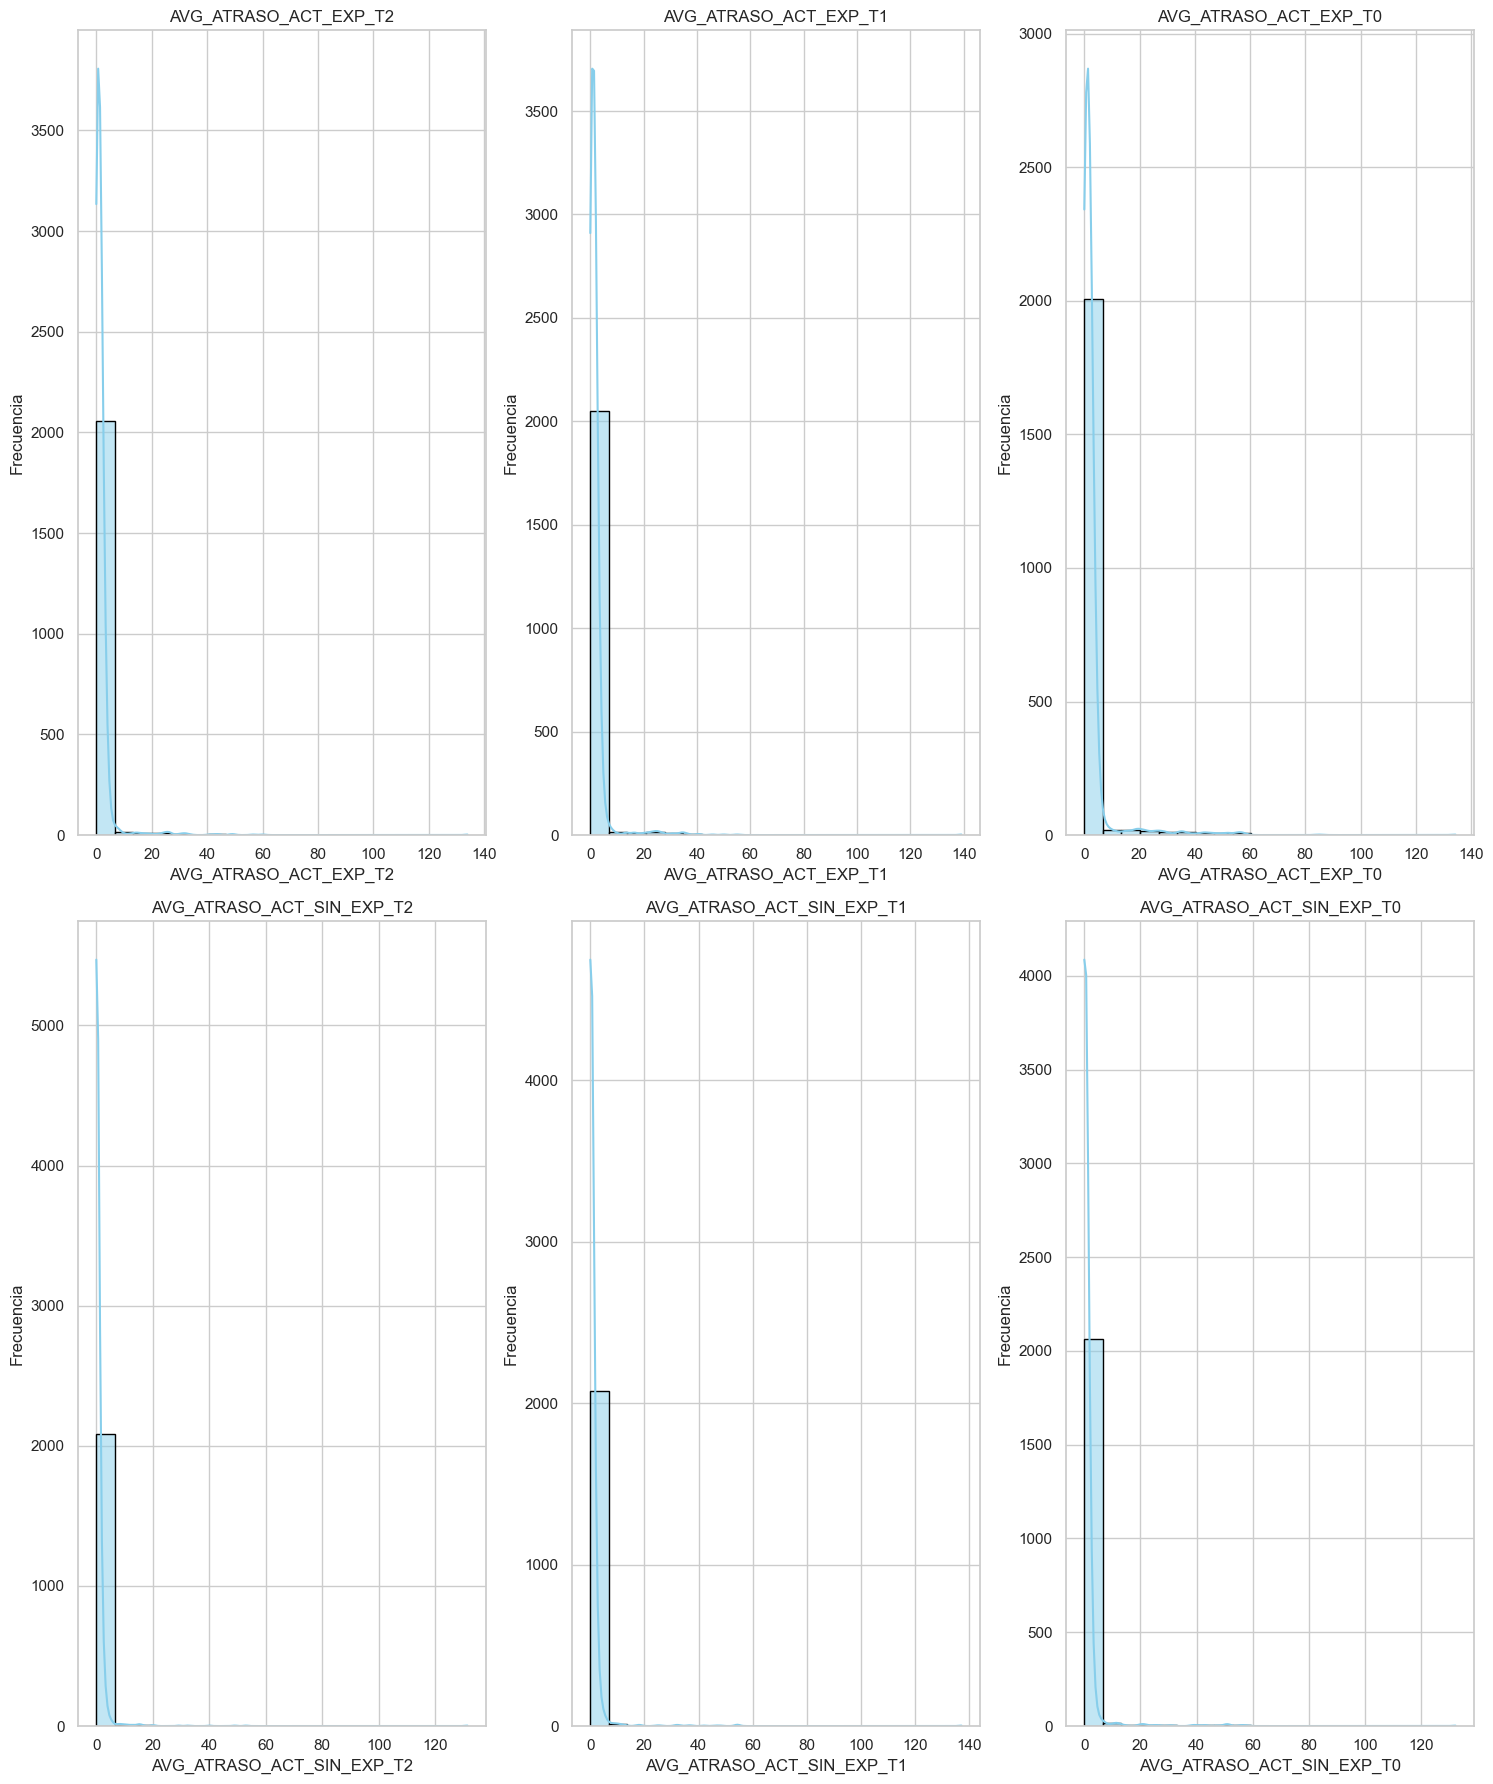

In [548]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 3, figsize=(15, 18))

axes = axes.flatten()

    
    
for i, columna in enumerate(dfAtraso.iloc[:,1:].columns):
    sns.histplot(dfAtraso[columna], bins=20, kde=True, color='skyblue', edgecolor='black', ax=axes[i])
    axes[i].set_title(f'{columna}')
    axes[i].set_xlabel(columna)
    axes[i].set_ylabel('Frecuencia')
    axes[i].grid(True)
plt.tight_layout()
plt.show()

***_Demográficos_***

In [549]:
ls_var_cliente = ['ASESOR_ID','CUSTOMER_ID','EDAD','GENDER_CD','TIME_BUSINESS_CD','TIME_BUSINESS_DESC',
                  'ECONOMIC_SECTOR_ACTIVITY_CD']
dfDemograficos = dfCliente[ls_var_cliente].drop_duplicates()

In [550]:
dfDemograficos.head()

,ASESOR_ID,CUSTOMER_ID,EDAD,GENDER_CD,TIME_BUSINESS_CD,TIME_BUSINESS_DESC,ECONOMIC_SECTOR_ACTIVITY_CD
0,8864775,15086,44,2,2,MENOS DE 6 MESES,30
3,44796482,15465,53,2,5,MAS DE 2 Y HASTA 3 AÑOS,28
4,1951589,15465,53,2,5,MAS DE 2 Y HASTA 3 AÑOS,28
6,62340668,15520,61,2,5,MAS DE 2 Y HASTA 3 AÑOS,28
9,65660011,15559,62,2,5,MAS DE 2 Y HASTA 3 AÑOS,8


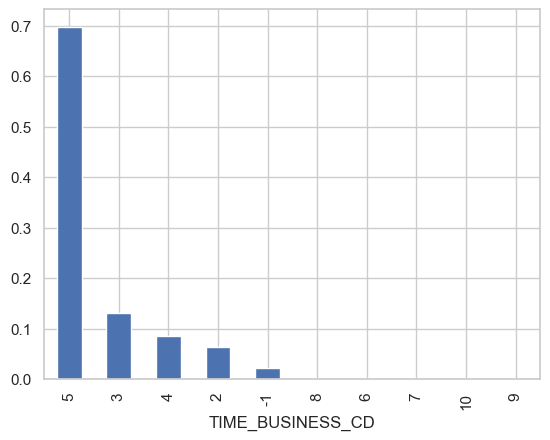

In [551]:
dfDemograficos.TIME_BUSINESS_CD.value_counts(True).plot(kind= 'bar')
plt.show()

In [552]:
dfDemograficos['TIME_BUSINESS_CD'] = np.where(dfDemograficos.TIME_BUSINESS_CD.isin([6,7,8,9,10,11]), 0, dfDemograficos.TIME_BUSINESS_CD)
dfDemograficos.TIME_BUSINESS_CD.value_counts(True)

TIME_BUSINESS_CD
 5    0.697442
 3    0.131386
 4    0.084393
 2    0.063905
-1    0.022522
 0    0.000353
Name: proportion, dtype: float64

In [553]:
ls_cols_TIME_BUSINESS = ['ASESOR_ID', 'TIME_BUSINESS_INDEFINIDO', 'TIME_BUSINESS_DEFAULT', 'TIME_BUSINESS_2','TIME_BUSINESS_3',
                         'TIME_BUSINESS_4', 'TIME_BUSINESS_5']

dfTiempoNegocio = pd.crosstab(index=dfDemograficos['ASESOR_ID'],
            columns=[dfDemograficos['TIME_BUSINESS_CD']],
            normalize='index').reset_index()

dfTiempoNegocio.columns = ls_cols_TIME_BUSINESS
dfTiempoNegocio.head()

,ASESOR_ID,TIME_BUSINESS_INDEFINIDO,TIME_BUSINESS_DEFAULT,TIME_BUSINESS_2,TIME_BUSINESS_3,TIME_BUSINESS_4,TIME_BUSINESS_5
0,1949827,0.000000,0.0,0.075862,0.165517,0.151724,0.606897
1,1949838,0.010453,0.0,0.041812,0.132404,0.059233,0.756098
2,1949853,0.006369,0.0,0.076433,0.140127,0.095541,0.681529
3,1950569,0.000000,0.0,0.050228,0.132420,0.114155,0.703196
4,1950587,0.010309,0.0,0.041237,0.103093,0.072165,0.773196


In [554]:
ls_genero = ['ASESOR_ID','GENERO_MASCULINO', 'GENERO_FEMENINO', 'EDAD_MASCULINO','EDAD_FEMENINO']

In [555]:
dfGenero =  pd.pivot_table(data=dfDemograficos,
               index='ASESOR_ID',
               columns='GENDER_CD',
               values = ['CUSTOMER_ID', 'EDAD'],
               aggfunc={'CUSTOMER_ID':'count', 'EDAD':'median'}
              ).reset_index()
dfGenero.columns = ls_genero
dfGenero['PORC_FEMENINO'] = dfGenero['GENERO_FEMENINO'] / (dfGenero['GENERO_MASCULINO'] + dfGenero['GENERO_FEMENINO'] )
dfGenero.head()

,ASESOR_ID,GENERO_MASCULINO,GENERO_FEMENINO,EDAD_MASCULINO,EDAD_FEMENINO,PORC_FEMENINO
0,1949827,62.0,83.0,43.0,42.0,0.572414
1,1949838,128.0,159.0,48.0,46.0,0.554007
2,1949853,68.0,89.0,48.5,46.0,0.566879
3,1950569,90.0,129.0,48.5,48.0,0.589041
4,1950587,58.0,136.0,51.0,49.0,0.701031


In [556]:
dfGenero = dfGenero[['ASESOR_ID','EDAD_MASCULINO','EDAD_FEMENINO','PORC_FEMENINO']]

In [557]:
dfGenero.head()

,ASESOR_ID,EDAD_MASCULINO,EDAD_FEMENINO,PORC_FEMENINO
0,1949827,43.0,42.0,0.572414
1,1949838,48.0,46.0,0.554007
2,1949853,48.5,46.0,0.566879
3,1950569,48.5,48.0,0.589041
4,1950587,51.0,49.0,0.701031


In [558]:
dfDemograficos.ECONOMIC_SECTOR_ACTIVITY_CD.unique()

array([30, 28,  8, 22, -1], dtype=int64)

In [559]:
dfDemograficos['ECONOMIC_SECTOR_ACTIVITY_CD'] = np.where(dfDemograficos.ECONOMIC_SECTOR_ACTIVITY_CD.isin([28,  8, 22, 30]), dfDemograficos.ECONOMIC_SECTOR_ACTIVITY_CD, 0)

In [560]:
ls_sector = ['ASESOR_ID','SECTOR_INDEF','SECTOR_8', 'SECTOR_22','SECTOR_28','SECTOR_30']
dfSector = pd.crosstab(index=dfDemograficos['ASESOR_ID'],
            columns=dfDemograficos['ECONOMIC_SECTOR_ACTIVITY_CD'], normalize='index').reset_index()
dfSector.columns = ls_sector
dfSector.drop(columns=['SECTOR_INDEF'], inplace=True)
dfSector.head()

,ASESOR_ID,SECTOR_8,SECTOR_22,SECTOR_28,SECTOR_30
0,1949827,0.241379,0.200000,0.351724,0.206897
1,1949838,0.324042,0.177700,0.358885,0.139373
2,1949853,0.210191,0.191083,0.464968,0.133758
3,1950569,0.278539,0.178082,0.351598,0.191781
4,1950587,0.278351,0.097938,0.510309,0.113402


***_Monto Prestado_***

In [561]:
cols_monto_prestado = ['ASESOR_ID',
                   'MONTO_PRESTADO_PROMEDIO_SE_T2','MONTO_PRESTADO_PROMEDIO_CE_T2',
                   'MONTO_PRESTADO_PROMEDIO_SE_T1','MONTO_PRESTADO_PROMEDIO_CE_T1',
                   'MONTO_PRESTADO_PROMEDIO_SE_T0','MONTO_PRESTADO_PROMEDIO_CE_T0']

In [562]:
dfMontoPrestado = pd.pivot_table(data = dfCliente,
               index = 'ASESOR_ID',
               columns = ['MES_CORTE','FLAG_EXPERIENCIA'],
               values = 'LOAN_CAPITAL_AMT',
               aggfunc = 'mean',
               fill_value = 0).reset_index()

dfMontoPrestado.columns = cols_monto_prestado
dfMontoPrestado.head()

,ASESOR_ID,MONTO_PRESTADO_PROMEDIO_SE_T2,MONTO_PRESTADO_PROMEDIO_CE_T2,MONTO_PRESTADO_PROMEDIO_SE_T1,MONTO_PRESTADO_PROMEDIO_CE_T1,MONTO_PRESTADO_PROMEDIO_SE_T0,MONTO_PRESTADO_PROMEDIO_CE_T0
0,1949827,57600.797748,120147.040667,62789.117543,124323.136250,62614.799391,134304.194000
1,1949838,49667.862321,73721.500469,48523.054634,67669.349059,50879.305138,66630.999483
2,1949853,67954.235398,90141.680370,70322.708878,90716.847238,70843.840360,97435.863667
3,1950569,80548.084052,96880.868704,87659.630262,98505.176663,88956.024180,94552.051692
4,1950587,40097.634732,65574.057000,40367.323332,63577.003281,41474.135918,64100.574571


***_Desembolso en TDD_***

In [563]:
ls_cols_desembolso = ['ASESOR_ID','TOTAL_DESEMBOLSO_TDD', 'TOTAL_CLIENTES']
dfDesembolso = dfCliente.groupby('ASESOR_ID').agg({'FLAG_DESEMBOLSO_TDD':['sum','count']}).reset_index()
dfDesembolso.columns = ls_cols_desembolso
dfDesembolso['PCNT_DESEMBOLSO_TDD'] = dfDesembolso['TOTAL_DESEMBOLSO_TDD']/dfDesembolso['TOTAL_CLIENTES']
dfDesembolso.head()

,ASESOR_ID,TOTAL_DESEMBOLSO_TDD,TOTAL_CLIENTES,PCNT_DESEMBOLSO_TDD
0,1949827,386,386,1.000000
1,1949838,648,648,1.000000
2,1949853,415,417,0.995204
3,1950569,521,528,0.986742
4,1950587,56,513,0.109162


In [564]:
dfDesembolso.PCNT_DESEMBOLSO_TDD.describe()

count    2108.000000
mean        0.841492
std         0.244895
min         0.000000
25%         0.766433
50%         0.975063
75%         1.000000
max         1.000000
Name: PCNT_DESEMBOLSO_TDD, dtype: float64

In [565]:
dfDesembolso = dfDesembolso[['ASESOR_ID','PCNT_DESEMBOLSO_TDD']]

In [566]:
dfDesembolso.head()

,ASESOR_ID,PCNT_DESEMBOLSO_TDD
0,1949827,1.000000
1,1949838,1.000000
2,1949853,0.995204
3,1950569,0.986742
4,1950587,0.109162


<Axes: xlabel='PCNT_DESEMBOLSO_TDD', ylabel='Count'>

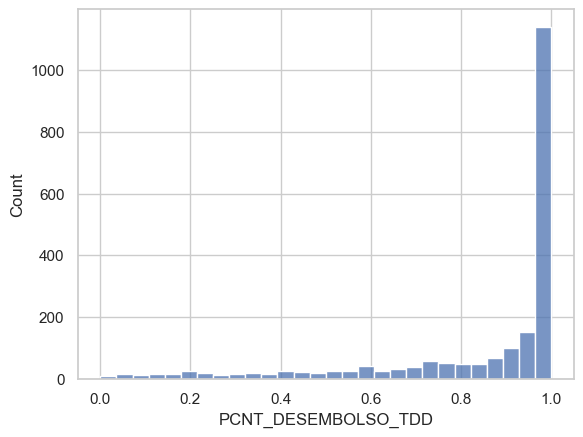

In [567]:
sns.histplot(data =dfDesembolso, x = 'PCNT_DESEMBOLSO_TDD')

***_Deterioro_***

In [568]:
cols_deterioro = [
    'ASESOR_ID', 'BUCKET_ATRASO_ANT',
    'ATRASO_0_T2', 'ATRASO_0_T1', 'ATRASO_0_T0',
    'ATRASO_1_7_T2', 'ATRASO_1_7_T1','ATRASO_1_7_T0',
    'ATRASO_8_60_T2', 'ATRASO_8_60_T1','ATRASO_8_60_T0', 
    'ATRASO_60m_T2', 'ATRASO_60m_T1', 'ATRASO_60m_T0',
    'CARTERA_0_T2', 'CARTERA_0_T1', 'CARTERA_0_T0',
    'CARTERA_1_7_T2', 'CARTERA_1_7_T1', 'CARTERA_1_7_T0',
    'CARTERA_8_60_T2', 'CARTERA_8_60_T1', 'CARTERA_8_60_T0',
    'CARTERA_60m_T2', 'CARTERA_60m_T1', 'CARTERA_60m_T0'
                 ]

In [569]:
dfDeterioro = pd.pivot_table(
    data=dfCliente,
    index=['ASESOR_ID','BUCKET_ATRASO_ANTERIOR'],
    columns=['BUCKET_ATRASO_ACTUAL','MES_CORTE'],
    values = ['CONTRACT_ID','MONTO_CARTERA'],
    aggfunc={'CONTRACT_ID':'count', 'MONTO_CARTERA':'sum'},
    fill_value=0
).reset_index()

dfDeterioro.columns = cols_deterioro

In [570]:
dfDeterioro.head()

,ASESOR_ID,BUCKET_ATRASO_ANT,ATRASO_0_T2,ATRASO_0_T1,ATRASO_0_T0,ATRASO_1_7_T2,ATRASO_1_7_T1,ATRASO_1_7_T0,ATRASO_8_60_T2,ATRASO_8_60_T1,ATRASO_8_60_T0,ATRASO_60m_T2,ATRASO_60m_T1,ATRASO_60m_T0,CARTERA_0_T2,CARTERA_0_T1,CARTERA_0_T0,CARTERA_1_7_T2,CARTERA_1_7_T1,CARTERA_1_7_T0,CARTERA_8_60_T2,CARTERA_8_60_T1,CARTERA_8_60_T0,CARTERA_60m_T2,CARTERA_60m_T1,CARTERA_60m_T0
0,1949827,a.CR0,108,104,106,0,0,0,2,7,1,0,0,0,4272991.92,5089617.98,5770219.87,0.0,0.00,0.0,66068.30,139374.10,1083.48,0.0,0.0,0.0
1,1949827,b.CR1a7,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0
2,1949827,d.CR8a60,1,0,1,0,0,0,2,3,5,0,0,0,9540.07,0.00,13288.23,0.0,0.00,0.0,138466.31,181715.23,101385.62,0.0,0.0,0.0
3,1949827,e.CR60+,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0
4,1949838,a.CR0,207,228,149,0,2,1,2,4,5,0,0,0,8169170.44,8541458.31,5785623.46,0.0,23721.72,20607.1,48498.05,126305.20,122622.00,0.0,0.0,0.0


In [571]:
dfDeterioro[dfDeterioro.ASESOR_ID==1949827].to_clipboard()

In [572]:
dfCliente[dfCliente.ASESOR_ID==1949827].to_clipboard()

In [573]:
dfDeterioroCtas = dfDeterioro[[
    'ASESOR_ID', 'BUCKET_ATRASO_ANT',
    'ATRASO_0_T2', 'ATRASO_0_T1', 'ATRASO_0_T0',
    'ATRASO_1_7_T2', 'ATRASO_1_7_T1','ATRASO_1_7_T0',
    'ATRASO_8_60_T2', 'ATRASO_8_60_T1','ATRASO_8_60_T0', 
    'ATRASO_60m_T2', 'ATRASO_60m_T1', 'ATRASO_60m_T0'
                          ]]

dfDeterioroCartera = dfDeterioro[[
    'ASESOR_ID', 'BUCKET_ATRASO_ANT',
    'CARTERA_0_T2', 'CARTERA_0_T1', 'CARTERA_0_T0',
    'CARTERA_1_7_T2', 'CARTERA_1_7_T1', 'CARTERA_1_7_T0',
    'CARTERA_8_60_T2', 'CARTERA_8_60_T1', 'CARTERA_8_60_T0',
    'CARTERA_60m_T2', 'CARTERA_60m_T1', 'CARTERA_60m_T0'
                          ]]

In [574]:
dfDeterioroCarteraCopy = dfDeterioroCartera.copy()

In [575]:
# Nos interesa bservar la transición de la cartera de 8 a 60 y 60+ por lo que nos quedamos solo con el bucket de interés
dfDeterioroCarteraCopy.drop(dfDeterioroCarteraCopy[dfDeterioroCarteraCopy.BUCKET_ATRASO_ANT.isin(['a.CR0','b.CR1a7','e.CR60+'])].index, axis=0, inplace=True)

In [576]:
dfDeterioroCarteraCopy.head()

,ASESOR_ID,BUCKET_ATRASO_ANT,CARTERA_0_T2,CARTERA_0_T1,CARTERA_0_T0,CARTERA_1_7_T2,CARTERA_1_7_T1,CARTERA_1_7_T0,CARTERA_8_60_T2,CARTERA_8_60_T1,CARTERA_8_60_T0,CARTERA_60m_T2,CARTERA_60m_T1,CARTERA_60m_T0
2,1949827,d.CR8a60,9540.07,0.00,13288.23,0.0,0.0,0.0,138466.31,181715.23,101385.62,0.00,0.00,0.0
6,1949838,d.CR8a60,0.00,0.00,0.00,0.0,0.0,0.0,139326.05,46160.19,147650.38,0.00,0.00,0.0
10,1949853,d.CR8a60,0.00,0.00,0.00,0.0,0.0,0.0,231267.92,113690.54,196215.24,0.00,0.00,0.0
14,1950569,d.CR8a60,0.00,0.00,72124.77,0.0,0.0,0.0,102334.19,137870.35,92988.73,0.00,0.00,0.0
18,1950587,d.CR8a60,0.00,35369.37,32735.41,0.0,0.0,0.0,738.99,738.99,21288.39,53290.89,2463.42,0.0


In [577]:
cols_T2 = [col for col in dfDeterioroCarteraCopy.columns if col.endswith('_T2')]
cols_T1 = [col for col in dfDeterioroCarteraCopy.columns if col.endswith('_T1')]
cols_T0 = [col for col in dfDeterioroCarteraCopy.columns if col.endswith('_T0')]

suma_T2 = dfDeterioroCarteraCopy[cols_T2].sum(axis=1)
suma_T1 = dfDeterioroCarteraCopy[cols_T1].sum(axis=1)
suma_T0 = dfDeterioroCarteraCopy[cols_T0].sum(axis=1)

dfDeterioroCarteraCopy['DETERIORO8A60_T2'] = dfDeterioroCarteraCopy['CARTERA_60m_T2'] / suma_T2
dfDeterioroCarteraCopy['DETERIORO8A60_T1'] = dfDeterioroCarteraCopy['CARTERA_60m_T1'] / suma_T1
dfDeterioroCarteraCopy['DETERIORO8A60_T0'] = dfDeterioroCarteraCopy['CARTERA_60m_T0'] / suma_T0

##dfDeterioroCarteraCopy['DETERIORO1A7_T2'] = dfDeterioroCarteraCopy['CARTERA_1_7_T2'] / suma_T2
##dfDeterioroCarteraCopy['DETERIORO1A7_T1'] = dfDeterioroCarteraCopy['CARTERA_1_7_T1'] / suma_T1
##dfDeterioroCarteraCopy['DETERIORO7A7_T0'] = dfDeterioroCarteraCopy['CARTERA_1_7_T0'] / suma_T0

In [578]:
dfDeterioroCarteraCopy[['DETERIORO8A60_T2','DETERIORO8A60_T1','DETERIORO8A60_T0']] = dfDeterioroCarteraCopy[['DETERIORO8A60_T2','DETERIORO8A60_T1','DETERIORO8A60_T0']].fillna(0)

In [579]:
dfDeterioroCarteraCopy.isnull().sum()

ASESOR_ID            0
BUCKET_ATRASO_ANT    0
CARTERA_0_T2         0
CARTERA_0_T1         0
CARTERA_0_T0         0
CARTERA_1_7_T2       0
CARTERA_1_7_T1       0
CARTERA_1_7_T0       0
CARTERA_8_60_T2      0
CARTERA_8_60_T1      0
CARTERA_8_60_T0      0
CARTERA_60m_T2       0
CARTERA_60m_T1       0
CARTERA_60m_T0       0
DETERIORO8A60_T2     0
DETERIORO8A60_T1     0
DETERIORO8A60_T0     0
dtype: int64

In [580]:
dfDeterioroCartera.shape

(8432, 14)

In [581]:
dfDeterioroCarteraCopy.head()

,ASESOR_ID,BUCKET_ATRASO_ANT,CARTERA_0_T2,CARTERA_0_T1,CARTERA_0_T0,CARTERA_1_7_T2,CARTERA_1_7_T1,CARTERA_1_7_T0,CARTERA_8_60_T2,CARTERA_8_60_T1,CARTERA_8_60_T0,CARTERA_60m_T2,CARTERA_60m_T1,CARTERA_60m_T0,DETERIORO8A60_T2,DETERIORO8A60_T1,DETERIORO8A60_T0
2,1949827,d.CR8a60,9540.07,0.00,13288.23,0.0,0.0,0.0,138466.31,181715.23,101385.62,0.00,0.00,0.0,0.000000,0.000000,0.0
6,1949838,d.CR8a60,0.00,0.00,0.00,0.0,0.0,0.0,139326.05,46160.19,147650.38,0.00,0.00,0.0,0.000000,0.000000,0.0
10,1949853,d.CR8a60,0.00,0.00,0.00,0.0,0.0,0.0,231267.92,113690.54,196215.24,0.00,0.00,0.0,0.000000,0.000000,0.0
14,1950569,d.CR8a60,0.00,0.00,72124.77,0.0,0.0,0.0,102334.19,137870.35,92988.73,0.00,0.00,0.0,0.000000,0.000000,0.0
18,1950587,d.CR8a60,0.00,35369.37,32735.41,0.0,0.0,0.0,738.99,738.99,21288.39,53290.89,2463.42,0.0,0.986323,0.063866,0.0


In [582]:
dfDeterioroCarteraCopy = dfDeterioroCarteraCopy[['ASESOR_ID','DETERIORO8A60_T2','DETERIORO8A60_T1','DETERIORO8A60_T0']]

In [583]:
dfDeterioroCarteraCopy['DETERIORO8A60_T2'].min(),dfDeterioroCarteraCopy['DETERIORO8A60_T2'].max(),dfDeterioroCarteraCopy['DETERIORO8A60_T1'].min(),dfDeterioroCarteraCopy['DETERIORO8A60_T1'].max()

(0.0, 1.0, 0.0, 1.0)

In [584]:
dfDeterioroCarteraCopy.head()

,ASESOR_ID,DETERIORO8A60_T2,DETERIORO8A60_T1,DETERIORO8A60_T0
2,1949827,0.000000,0.000000,0.0
6,1949838,0.000000,0.000000,0.0
10,1949853,0.000000,0.000000,0.0
14,1950569,0.000000,0.000000,0.0
18,1950587,0.986323,0.063866,0.0


In [585]:
def calcular_se_mantiene_0(matriz):
    return matriz[0, 0] if matriz.shape[0] > 0 and matriz.shape[1] > 0 else np.nan

def calcular_se_mantiene_atraso(matriz):
    return np.trace(matriz[1:, 1:]) if matriz.shape[0] > 1 and matriz.shape[1] > 1 else 0

def calcular_mejora(matriz):
    return np.nansum(np.tril(matriz, -1))

def calcular_empeora(matriz):
    return np.nansum(np.triu(matriz, 1))

***_Deterioro en monto de cartera por asesor_***

In [586]:
resultados = []

for asesor_id, grupo in dfDeterioroCartera.groupby("ASESOR_ID"):
    # Ordenamos las filas por bucket para consistencia
    grupo = grupo.sort_values('BUCKET_ATRASO_ANT')
    # Filtrar matrices por periodo
    matriz1 = grupo.filter(regex='_T2$') 
    matriz2 = grupo.filter(regex='_T1$')
    matriz3 = grupo.filter(regex='_T0$')
    # Aseguramos que todo sea numérico
    matriz1 = matriz1.apply(pd.to_numeric, errors='coerce')
    matriz2 = matriz2.apply(pd.to_numeric, errors='coerce')
    matriz3 = matriz3.apply(pd.to_numeric, errors='coerce')
    # Convertimos a numpy para los cálculos
    m1_np = matriz1.values
    m2_np = matriz2.values
    m3_np = matriz3.values
    # Sumas totales
    suma_matriz1 = np.nansum(m1_np)
    suma_matriz2 = np.nansum(m2_np)
    suma_matriz3 = np.nansum(m3_np)
    # Cálculos específicos
    resultados.append({
        "ASESOR_ID": asesor_id,
        "TOTAL_CARTERA_T2": suma_matriz1,
        "TOTAL_CARTERA_T1": suma_matriz2,
        "TOTAL_CARTERA_T0": suma_matriz3,
        "SE_MANTIENE_0_T2": calcular_se_mantiene_0(m1_np),
        "SE_MANTIENE_ATRASO_T2": calcular_se_mantiene_atraso(m1_np),
        "MEJORA_T2": calcular_mejora(m1_np),
        "EMPEORA_T2": calcular_empeora(m1_np),
        "SE_MANTIENE_0_T1": calcular_se_mantiene_0(m2_np),
        "SE_MANTIENE_ATRASO_T1": calcular_se_mantiene_atraso(m2_np),
        "MEJORA_T1": calcular_mejora(m2_np),
        "EMPEORA_T1": calcular_empeora(m2_np),
        "SE_MANTIENE_0_T0": calcular_se_mantiene_0(m3_np),
        "SE_MANTIENE_ATRASO_T0": calcular_se_mantiene_atraso(m3_np),
        "MEJORA_T0": calcular_mejora(m3_np),
        "EMPEORA_T0": calcular_empeora(m3_np)
    })

resultadosCartera = pd.DataFrame(resultados)

In [587]:
resultadosCartera[resultadosCartera.ASESOR_ID==1949827]

,ASESOR_ID,TOTAL_CARTERA_T2,TOTAL_CARTERA_T1,TOTAL_CARTERA_T0,SE_MANTIENE_0_T2,SE_MANTIENE_ATRASO_T2,MEJORA_T2,EMPEORA_T2,SE_MANTIENE_0_T1,SE_MANTIENE_ATRASO_T1,MEJORA_T1,EMPEORA_T1,SE_MANTIENE_0_T0,SE_MANTIENE_ATRASO_T0,MEJORA_T0,EMPEORA_T0
0,1949827,4487066.6,5410707.31,5885977.2,4272991.92,138466.31,9540.07,66068.3,5089617.98,181715.23,0.0,139374.1,5770219.87,101385.62,13288.23,1083.48


In [588]:
#DETERIORO DE CARTERA T2
resultadosCartera['SE_MANTIENE_0_PCT_T2'] = resultadosCartera['SE_MANTIENE_0_T2']/resultadosCartera['TOTAL_CARTERA_T2']
resultadosCartera['SE_MANTIENE_ATRASO_PCT_T2'] = resultadosCartera['SE_MANTIENE_ATRASO_T2']/resultadosCartera['TOTAL_CARTERA_T2']
resultadosCartera['MEJORA_PCT_T2'] = resultadosCartera['MEJORA_T2']/resultadosCartera['TOTAL_CARTERA_T2']
resultadosCartera['EMPEORA_T2'] = resultadosCartera['EMPEORA_T2']/resultadosCartera['TOTAL_CARTERA_T2']

#DETERIORO DE CARTERA T1
resultadosCartera['SE_MANTIENE_0_PCT_T1'] = resultadosCartera['SE_MANTIENE_0_T1']/resultadosCartera['TOTAL_CARTERA_T1']
resultadosCartera['SE_MANTIENE_ATRASO_PCT_T1'] = resultadosCartera['SE_MANTIENE_ATRASO_T1']/resultadosCartera['TOTAL_CARTERA_T1']
resultadosCartera['MEJORA_PCT_T1'] = resultadosCartera['MEJORA_T1']/resultadosCartera['TOTAL_CARTERA_T1']
resultadosCartera['EMPEORA_T1'] = resultadosCartera['EMPEORA_T1']/resultadosCartera['TOTAL_CARTERA_T1']

#DETERIORO DE CARTERA T0
resultadosCartera['SE_MANTIENE_0_PCT_T0'] = resultadosCartera['SE_MANTIENE_0_T0']/resultadosCartera['TOTAL_CARTERA_T0']
resultadosCartera['SE_MANTIENE_ATRASO_PCT_T0'] = resultadosCartera['SE_MANTIENE_ATRASO_T0']/resultadosCartera['TOTAL_CARTERA_T0']
resultadosCartera['MEJORA_PCT_T0'] = resultadosCartera['MEJORA_T0']/resultadosCartera['TOTAL_CARTERA_T0']
resultadosCartera['EMPEORA_T0'] = resultadosCartera['EMPEORA_T0']/resultadosCartera['TOTAL_CARTERA_T0']

In [589]:
resultadosCartera[resultadosCartera.SE_MANTIENE_0_PCT_T2.isnull()].head(5)

,ASESOR_ID,TOTAL_CARTERA_T2,TOTAL_CARTERA_T1,TOTAL_CARTERA_T0,SE_MANTIENE_0_T2,SE_MANTIENE_ATRASO_T2,MEJORA_T2,EMPEORA_T2,SE_MANTIENE_0_T1,SE_MANTIENE_ATRASO_T1,MEJORA_T1,EMPEORA_T1,SE_MANTIENE_0_T0,SE_MANTIENE_ATRASO_T0,MEJORA_T0,EMPEORA_T0,SE_MANTIENE_0_PCT_T2,SE_MANTIENE_ATRASO_PCT_T2,MEJORA_PCT_T2,SE_MANTIENE_0_PCT_T1,SE_MANTIENE_ATRASO_PCT_T1,MEJORA_PCT_T1,SE_MANTIENE_0_PCT_T0,SE_MANTIENE_ATRASO_PCT_T0,MEJORA_PCT_T0
12,1953602,0.0,4652058.83,549561.24,0.0,0.0,0.0,NaN,3764938.28,163923.18,304210.45,0.090065,0.00,348298.65,0.00,0.366224,NaN,NaN,NaN,0.809306,0.035237,0.065393,0.000000,0.633776,0.000000
25,1956550,0.0,2467676.72,1947945.22,0.0,0.0,0.0,NaN,1813572.39,6158.84,0.00,0.262573,1231996.70,310669.46,69759.19,0.172243,NaN,NaN,NaN,0.734931,0.002496,0.000000,0.632460,0.159486,0.035812
26,1956553,0.0,0.00,5547947.78,0.0,0.0,0.0,NaN,0.00,0.00,0.00,NaN,5499321.13,0.00,0.00,0.008765,NaN,NaN,NaN,NaN,NaN,NaN,0.991235,0.000000,0.000000
45,3818547,0.0,0.00,0.00,0.0,0.0,0.0,NaN,0.00,0.00,0.00,NaN,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,3945312,0.0,184262.49,93071.34,0.0,0.0,0.0,NaN,101700.56,0.00,0.00,0.448067,93071.34,0.00,0.00,0.000000,NaN,NaN,NaN,0.551933,0.000000,0.000000,1.000000,0.000000,0.000000


In [590]:
resultadosCartera[resultadosCartera.TOTAL_CARTERA_T2==0].shape, resultadosCartera[resultadosCartera.TOTAL_CARTERA_T1==0].shape, resultadosCartera[resultadosCartera.TOTAL_CARTERA_T0==0].shape

((259, 25), (158, 25), (29, 25))

In [591]:
resultadosCartera[resultadosCartera.TOTAL_CARTERA_T0==0].head(5)

,ASESOR_ID,TOTAL_CARTERA_T2,TOTAL_CARTERA_T1,TOTAL_CARTERA_T0,SE_MANTIENE_0_T2,SE_MANTIENE_ATRASO_T2,MEJORA_T2,EMPEORA_T2,SE_MANTIENE_0_T1,SE_MANTIENE_ATRASO_T1,MEJORA_T1,EMPEORA_T1,SE_MANTIENE_0_T0,SE_MANTIENE_ATRASO_T0,MEJORA_T0,EMPEORA_T0,SE_MANTIENE_0_PCT_T2,SE_MANTIENE_ATRASO_PCT_T2,MEJORA_PCT_T2,SE_MANTIENE_0_PCT_T1,SE_MANTIENE_ATRASO_PCT_T1,MEJORA_PCT_T1,SE_MANTIENE_0_PCT_T0,SE_MANTIENE_ATRASO_PCT_T0,MEJORA_PCT_T0
45,3818547,0.00,0.00,0.0,0.00,0.00,0.00,NaN,0.00,0.00,0.00,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,6847014,200026.79,0.00,0.0,0.00,200026.79,0.00,0.000000,0.00,0.00,0.00,NaN,0.0,0.0,0.0,NaN,0.000000,1.00000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
156,9924592,0.00,0.00,0.0,0.00,0.00,0.00,NaN,0.00,0.00,0.00,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
368,22061010,7905583.47,8605637.62,0.0,7424304.77,214479.73,73870.91,0.024404,8216013.99,87697.72,31170.09,0.031463,0.0,0.0,0.0,NaN,0.939122,0.02713,0.009344,0.954725,0.010191,0.003622,NaN,NaN,NaN
404,23506013,0.00,0.00,0.0,0.00,0.00,0.00,NaN,0.00,0.00,0.00,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [592]:
resultadosCartera[resultadosCartera.ASESOR_ID==83758419]

,ASESOR_ID,TOTAL_CARTERA_T2,TOTAL_CARTERA_T1,TOTAL_CARTERA_T0,SE_MANTIENE_0_T2,SE_MANTIENE_ATRASO_T2,MEJORA_T2,EMPEORA_T2,SE_MANTIENE_0_T1,SE_MANTIENE_ATRASO_T1,MEJORA_T1,EMPEORA_T1,SE_MANTIENE_0_T0,SE_MANTIENE_ATRASO_T0,MEJORA_T0,EMPEORA_T0,SE_MANTIENE_0_PCT_T2,SE_MANTIENE_ATRASO_PCT_T2,MEJORA_PCT_T2,SE_MANTIENE_0_PCT_T1,SE_MANTIENE_ATRASO_PCT_T1,MEJORA_PCT_T1,SE_MANTIENE_0_PCT_T0,SE_MANTIENE_ATRASO_PCT_T0,MEJORA_PCT_T0
1446,83758419,8024681.49,8726121.31,9143352.41,7864836.51,101683.41,35577.99,0.002814,8526779.31,21474.58,0.0,0.020383,8939736.59,131578.02,56235.3,0.001728,0.980081,0.012671,0.004434,0.977156,0.002461,0.0,0.977731,0.014391,0.00615


In [593]:
dfCliente[dfCliente.ASESOR_ID==10307081].groupby('FECHA_CORTE')['MONTO_CARTERA'].sum()

FECHA_CORTE
2025-02-28     9343382.29
2025-03-31    10204886.46
2025-04-30    11708534.69
Name: MONTO_CARTERA, dtype: float64

In [594]:
dfHist[dfHist.EMPLOYEE_ID==10307081]

,EMPLOYEE_ID,EMPLOYEE_PAYROLL_NUM,CARTERA_ASESOR,CR1_7,CR8_8_60,CRMAS_60,SINATRASO,CORTE,PCNT_CR_8a60,COSECHA
864,10307081,37576,8206130.25,0.0,44417.66,0.0,8161712.59,2024-12-31,0.54,202412
1879,10307081,37576,10204886.46,0.0,188187.88,0.0,10016698.58,2025-03-31,1.84,202503
2921,10307081,37576,11708534.69,0.0,203834.34,0.0,11504700.35,2025-04-30,1.74,202504
3776,10307081,37576,9343382.29,0.0,0.00,0.0,9343382.29,2025-02-28,0.00,202502
4745,10307081,37576,8679995.42,0.0,44417.66,0.0,8635577.76,2025-01-31,0.51,202501
5740,10307081,37576,8564934.09,0.0,730654.35,0.0,7834279.74,2024-11-30,8.53,202411
6727,10307081,37576,7074544.45,0.0,643955.20,0.0,6430589.25,2024-09-30,9.10,202409
8074,10307081,37576,8117027.45,0.0,859958.91,0.0,7257068.54,2024-10-31,10.59,202410
14256,10307081,37576,1038183.68,0.0,0.00,0.0,1038183.68,2024-08-31,0.00,202408


In [595]:
dfCliente[dfCliente.ASESOR_ID==11144414]

,CONTRACT_ID,CUSTOMER_ID,LOAN_CAPITAL_AMT,ASESOR_ID,CONTRACT_STATUS_CD,CICLO_CI,CICLOS_TOTAL_GRUPAL,CICLOS_EJE,EDAD,GENDER_CD,TIME_BUSINESS_CD,TIME_BUSINESS_DESC,ECONOMIC_SECTOR_ACTIVITY_CD,MODALIDAD,ID_METODO_DISPERSION,DISBMNT_AMT,CUSTOMER_ORIG_ID,CONTRACT_START_DT,CONTRACT_END_DT,MONTO_CARTERA,DIAS_ATRASO_ACTUAL,FECHA_CORTE,FLAG_TR,TR,FLAG_VC,FLAG_MAC,FLAG_AMI,FLAG_FPD,DIAS_ATRASO_MES_ANT,MONTO_CARTERA_ANT,ASESOR_ORIGINADOR,FLAG_ORIGINADOR,FLAG_NUEVOS_PUROS,FLAG_NUEVOS_PRODUCTO,FLAG_SEGURO_VOLUNTARIO,FLAG_SEGURO_FAMILIAR,COSECHA,MES_CORTE,MES_FIN,FLAG_COLOCACION_MES,FLAG_SIN_CARTERA,FLAG_NUEVOS_PUROS_MES,FLAG_NUEVOS_PRODUCTO_MES,FLAG_EXPERIENCIA_CI,BUCKET_ATRASO_ACTUAL,BUCKET_ATRASO_ANTERIOR,FLAG_DESEMBOLSO_TDD,FLAG_EXPERIENCIA_GRUPAL,FLAG_EXPERIENCIA,RANGO_CICLO_CI
2104,137586714,83993831,52573.60,11144414,1,2,0,2,42,2,5,MAS DE 2 Y HASTA 3 AÑOS,28,1,1.0,50000.41,85946798,2025-01-31,2026-05-05,52573.60,0,2025-02-28,1,None,0,1,0,1,0.0,52573.60,11144414.0,0,0,0,1,1,202501,202502,202605,0,0,0,0,0,a.CR0,a.CR0,0,0,0,b.2
2105,137586714,83993831,52573.60,11144414,1,2,0,2,42,2,5,MAS DE 2 Y HASTA 3 AÑOS,28,1,1.0,50000.41,85946798,2025-01-31,2026-05-05,47950.04,0,2025-04-30,1,None,0,1,0,1,0.0,50329.95,11144414.0,0,0,0,1,1,202501,202504,202605,0,0,0,0,0,a.CR0,a.CR0,0,0,0,b.2
2106,137586714,83993831,52573.60,11144414,1,2,0,2,42,2,5,MAS DE 2 Y HASTA 3 AÑOS,28,1,1.0,50000.41,85946798,2025-01-31,2026-05-05,50329.95,0,2025-03-31,1,None,0,1,0,1,0.0,52573.60,11144414.0,0,0,0,1,1,202501,202503,202605,0,0,0,0,0,a.CR0,a.CR0,0,0,0,b.2
2113,133805490,83994031,32852.49,11144414,1,1,1,2,24,2,4,DE 1 Y HASTA 2 AÑOS,30,1,3.0,30005.57,85947008,2024-09-23,2025-11-01,25803.26,0,2025-02-28,1,None,0,1,0,0,0.0,27762.01,78702761.0,1,0,1,1,1,202409,202502,202511,0,0,0,0,0,a.CR0,a.CR0,1,1,0,a.1
2114,133805490,83994031,32852.49,11144414,1,1,1,2,24,2,4,DE 1 Y HASTA 2 AÑOS,30,1,3.0,30005.57,85947008,2024-09-23,2025-11-01,23696.82,0,2025-03-31,1,None,0,1,0,0,0.0,25803.26,78702761.0,1,0,1,1,1,202409,202503,202511,0,0,0,0,0,a.CR0,a.CR0,1,1,0,a.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816755,133018079,29775946,32095.79,11144414,1,1,0,1,68,1,5,MAS DE 2 Y HASTA 3 AÑOS,30,1,3.0,30005.86,69015831,2024-08-26,2025-09-03,19492.68,0,2025-03-31,1,None,0,1,0,0,0.0,21992.45,78702761.0,1,1,1,1,1,202408,202503,202509,0,0,0,0,0,a.CR0,a.CR0,1,0,0,a.1
816756,133018079,29775946,32095.79,11144414,1,1,0,1,68,1,5,MAS DE 2 Y HASTA 3 AÑOS,30,1,3.0,30005.86,69015831,2024-08-26,2025-09-03,21992.45,0,2025-02-28,1,None,0,1,0,0,0.0,24316.95,78702761.0,1,1,1,1,1,202408,202502,202509,0,0,0,0,0,a.CR0,a.CR0,1,0,0,a.1
821396,135842570,90674596,53250.25,11144414,1,1,0,1,21,1,3,MENOS DE 1 AÑO,28,0,1.0,51008.17,87422634,2024-11-29,2025-12-13,41487.11,0,2025-03-31,1,None,0,0,0,0,0.0,44730.84,11144414.0,0,1,1,0,0,202411,202503,202512,0,0,0,0,0,a.CR0,a.CR0,0,0,0,a.1
821450,134362828,79748941,82494.63,11144414,1,3,0,3,71,2,5,MAS DE 2 Y HASTA 3 AÑOS,30,1,1.0,80002.59,84779446,2024-10-15,2026-01-01,66705.31,0,2025-02-28,1,None,0,0,0,0,0.0,70986.70,78702761.0,1,0,0,1,1,202410,202502,202601,0,0,0,0,0,a.CR0,a.CR0,0,0,0,c.3


In [596]:
dfCliente[dfCliente.MES_CORTE=='202410'].groupby('ASESOR_ID')['MONTO_CARTERA'].sum().to_frame().to_clipboard()

In [597]:
dfHist[dfHist.COSECHA=='202410'][['EMPLOYEE_ID','CARTERA_ASESOR']].to_clipboard()

In [598]:
resultadosCartera=resultadosCartera[['ASESOR_ID',
                                     'SE_MANTIENE_0_PCT_T0','SE_MANTIENE_ATRASO_PCT_T0','MEJORA_PCT_T0','EMPEORA_T0',
                                     'SE_MANTIENE_0_PCT_T1','SE_MANTIENE_ATRASO_PCT_T1','MEJORA_PCT_T1','EMPEORA_T1',
                                     'SE_MANTIENE_0_PCT_T2','SE_MANTIENE_ATRASO_PCT_T2','MEJORA_PCT_T2','EMPEORA_T2'
                                    ]]

In [599]:
resultadosCartera.head()

,ASESOR_ID,SE_MANTIENE_0_PCT_T0,SE_MANTIENE_ATRASO_PCT_T0,MEJORA_PCT_T0,EMPEORA_T0,SE_MANTIENE_0_PCT_T1,SE_MANTIENE_ATRASO_PCT_T1,MEJORA_PCT_T1,EMPEORA_T1,SE_MANTIENE_0_PCT_T2,SE_MANTIENE_ATRASO_PCT_T2,MEJORA_PCT_T2,EMPEORA_T2
0,1949827,0.980333,0.017225,0.002258,0.000184,0.940657,0.033584,0.000000,0.025759,0.952291,0.030859,0.002126,0.014724
1,1949838,0.947311,0.024176,0.001762,0.026752,0.975767,0.007094,0.000000,0.017139,0.972529,0.021697,0.000000,0.005774
2,1949853,0.957231,0.033341,0.000000,0.009427,0.963745,0.019573,0.000000,0.016682,0.946867,0.041034,0.005741,0.006358
3,1950569,0.979191,0.007973,0.006184,0.006651,0.977760,0.014206,0.000000,0.008034,0.974947,0.011521,0.000000,0.013532
4,1950587,0.905127,0.023678,0.006508,0.064688,0.927481,0.019092,0.012784,0.040644,0.923231,0.009246,0.034343,0.033179


In [600]:
resultadosCartera.shape,resultadosCartera.SE_MANTIENE_0_PCT_T0.min(),resultadosCartera.SE_MANTIENE_0_PCT_T0.max()

((2108, 13), 0.0, 1.0)

In [601]:
resultadosCartera[resultadosCartera.ASESOR_ID==5361942]

,ASESOR_ID,SE_MANTIENE_0_PCT_T0,SE_MANTIENE_ATRASO_PCT_T0,MEJORA_PCT_T0,EMPEORA_T0,SE_MANTIENE_0_PCT_T1,SE_MANTIENE_ATRASO_PCT_T1,MEJORA_PCT_T1,EMPEORA_T1,SE_MANTIENE_0_PCT_T2,SE_MANTIENE_ATRASO_PCT_T2,MEJORA_PCT_T2,EMPEORA_T2


In [602]:
dfAsesor[dfAsesor.ASESOR_ID==5361942]

,ASESOR_ID,POSITION_DESC,ANT_ASESOR,C_COBRANZA_T0,C_COBRANZA_T1,C_COBRANZA_T2,HORAS_VUELO,PORCT_RENOV_T2,PORCT_RENOV_T1,PORCT_RENOV_T0


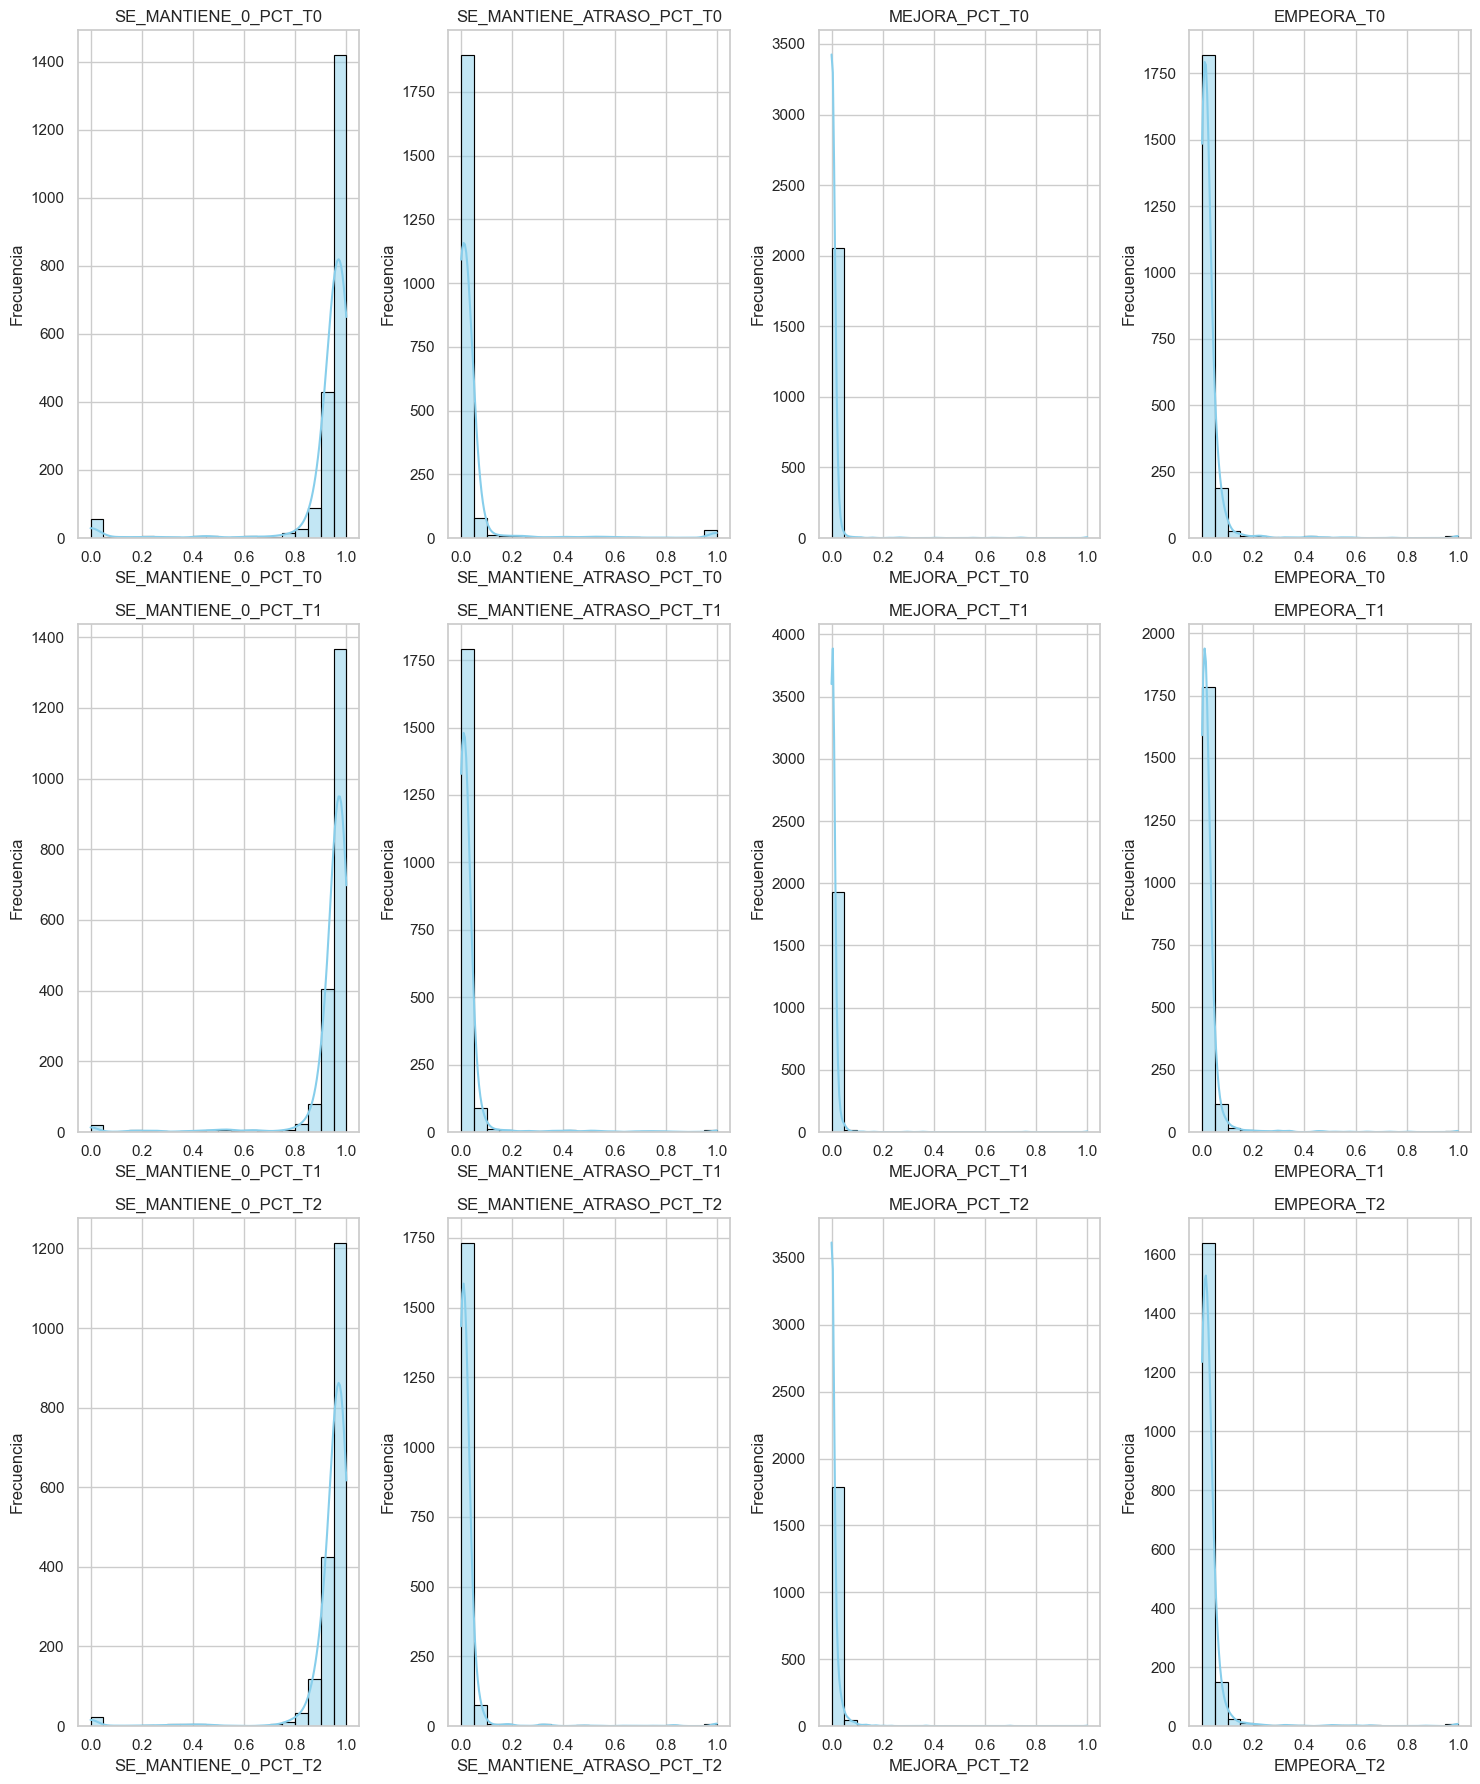

In [603]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(3, 4, figsize=(15, 18))

axes = axes.flatten()
for i, columna in enumerate(resultadosCartera.iloc[:,1:].columns):
    sns.histplot(resultadosCartera[columna], bins=20, kde=True, color='skyblue', edgecolor='black', ax=axes[i])
    axes[i].set_title(f'{columna}')
    axes[i].set_xlabel(columna)
    axes[i].set_ylabel('Frecuencia')
    axes[i].grid(True)
plt.tight_layout()
plt.show()

***_Deterioro en contratos por asesor_***

In [604]:
resultadoscontratos = []

for asesor_id, grupo in dfDeterioroCtas.groupby("ASESOR_ID"):
    # Ordenamos las filas por bucket para consistencia
    grupo = grupo.sort_values('BUCKET_ATRASO_ANT')
    # Filtrar matrices por periodo
    matriz1 = grupo.filter(regex='_T2$') 
    matriz2 = grupo.filter(regex='_T1$')
    matriz3 = grupo.filter(regex='_T0$')
    # Aseguramos que todo sea numérico
    matriz1 = matriz1.apply(pd.to_numeric, errors='coerce')
    matriz2 = matriz2.apply(pd.to_numeric, errors='coerce')
    matriz3 = matriz3.apply(pd.to_numeric, errors='coerce')
    # Convertimos a numpy para los cálculos
    m1_np = matriz1.values
    m2_np = matriz2.values
    m3_np = matriz3.values
    # Sumas totales
    suma_matriz1 = np.nansum(m1_np)
    suma_matriz2 = np.nansum(m2_np)
    suma_matriz3 = np.nansum(m3_np)
    # Cálculos específicos
    resultadoscontratos.append({
        "ASESOR_ID": asesor_id,
        "TOTAL_CUENTAS_T2": suma_matriz1,
        "TOTAL_CUENTAS_T1": suma_matriz2,
        "TOTAL_CUENTAS_T0": suma_matriz3,
        "SE_MANTIENE_0_T2": calcular_se_mantiene_0(m1_np),
        "SE_MANTIENE_ATRASO_T2": calcular_se_mantiene_atraso(m1_np),
        "MEJORA_T2": calcular_mejora(m1_np),
        "EMPEORA_T2": calcular_empeora(m1_np),
        "SE_MANTIENE_0_T1": calcular_se_mantiene_0(m2_np),
        "SE_MANTIENE_ATRASO_T1": calcular_se_mantiene_atraso(m2_np),
        "MEJORA_T1": calcular_mejora(m2_np),
        "EMPEORA_T1": calcular_empeora(m2_np),
        "SE_MANTIENE_0_T0": calcular_se_mantiene_0(m3_np),
        "SE_MANTIENE_ATRASO_T0": calcular_se_mantiene_atraso(m3_np),
        "MEJORA_T0": calcular_mejora(m3_np),
        "EMPEORA_T0": calcular_empeora(m3_np)
    })

resultadosContratos = pd.DataFrame(resultadoscontratos)
resultadosContratos.head()

,ASESOR_ID,TOTAL_CUENTAS_T2,TOTAL_CUENTAS_T1,TOTAL_CUENTAS_T0,SE_MANTIENE_0_T2,SE_MANTIENE_ATRASO_T2,MEJORA_T2,EMPEORA_T2,SE_MANTIENE_0_T1,SE_MANTIENE_ATRASO_T1,MEJORA_T1,EMPEORA_T1,SE_MANTIENE_0_T0,SE_MANTIENE_ATRASO_T0,MEJORA_T0,EMPEORA_T0
0,1949827,113,114,113,108,2,1,2,104,3,0,7,106,5,1,1
1,1949838,215,237,163,207,6,0,2,228,3,0,6,149,5,1,8
2,1949853,131,123,125,123,5,2,1,119,2,0,2,119,4,0,2
3,1950569,152,151,174,145,5,0,2,143,4,0,4,166,5,1,2
4,1950587,172,149,156,151,5,8,8,129,6,4,10,133,7,2,14


In [605]:
#DETERIORO DE CARTERA T2
resultadosContratos['SE_MANTIENE_0_PCT_CATS_T2'] = resultadosContratos['SE_MANTIENE_0_T2']/resultadosContratos['TOTAL_CUENTAS_T2']
resultadosContratos['SE_MANTIENE_ATRASO_PCT_CATS_T2'] = resultadosContratos['SE_MANTIENE_ATRASO_T2']/resultadosContratos['TOTAL_CUENTAS_T2']
resultadosContratos['MEJORA_PCT_CATS_T2'] = resultadosContratos['MEJORA_T2']/resultadosContratos['TOTAL_CUENTAS_T2']
resultadosContratos['EMPEORA_CATS_T2'] = resultadosContratos['EMPEORA_T2']/resultadosContratos['TOTAL_CUENTAS_T2']

#DETERIORO DE CARTERA T1
resultadosContratos['SE_MANTIENE_0_PCT_CATS_T1'] = resultadosContratos['SE_MANTIENE_0_T1']/resultadosContratos['TOTAL_CUENTAS_T1']
resultadosContratos['SE_MANTIENE_ATRASO_PCT_CATS_T1'] = resultadosContratos['SE_MANTIENE_ATRASO_T1']/resultadosContratos['TOTAL_CUENTAS_T1']
resultadosContratos['MEJORA_PCT_CATS_T1'] = resultadosContratos['MEJORA_T1']/resultadosContratos['TOTAL_CUENTAS_T1']
resultadosContratos['EMPEORA_CATS_T1'] = resultadosContratos['EMPEORA_T1']/resultadosContratos['TOTAL_CUENTAS_T1']

#DETERIORO DE CARTERA T0
resultadosContratos['SE_MANTIENE_0_PCT_CATS_T0'] = resultadosContratos['SE_MANTIENE_0_T0']/resultadosContratos['TOTAL_CUENTAS_T0']
resultadosContratos['SE_MANTIENE_ATRASO_PCT_CATS_T0'] = resultadosContratos['SE_MANTIENE_ATRASO_T0']/resultadosContratos['TOTAL_CUENTAS_T0']
resultadosContratos['MEJORA_PCT_CATS_T0'] = resultadosContratos['MEJORA_T0']/resultadosContratos['TOTAL_CUENTAS_T0']
resultadosContratos['EMPEORA_CATS_T0'] = resultadosContratos['EMPEORA_T0']/resultadosContratos['TOTAL_CUENTAS_T0']

In [606]:
resultadosContratos=resultadosContratos[['ASESOR_ID',
                                     'SE_MANTIENE_0_PCT_CATS_T0','SE_MANTIENE_ATRASO_PCT_CATS_T0','MEJORA_PCT_CATS_T0','EMPEORA_CATS_T0',
                                     'SE_MANTIENE_0_PCT_CATS_T1','SE_MANTIENE_ATRASO_PCT_CATS_T1','MEJORA_PCT_CATS_T1','EMPEORA_CATS_T1',
                                     'SE_MANTIENE_0_PCT_CATS_T2','SE_MANTIENE_ATRASO_PCT_CATS_T2','MEJORA_PCT_CATS_T2','EMPEORA_CATS_T2',
                                    ]]

In [607]:
resultadosContratos.head()

,ASESOR_ID,SE_MANTIENE_0_PCT_CATS_T0,SE_MANTIENE_ATRASO_PCT_CATS_T0,MEJORA_PCT_CATS_T0,EMPEORA_CATS_T0,SE_MANTIENE_0_PCT_CATS_T1,SE_MANTIENE_ATRASO_PCT_CATS_T1,MEJORA_PCT_CATS_T1,EMPEORA_CATS_T1,SE_MANTIENE_0_PCT_CATS_T2,SE_MANTIENE_ATRASO_PCT_CATS_T2,MEJORA_PCT_CATS_T2,EMPEORA_CATS_T2
0,1949827,0.938053,0.044248,0.008850,0.008850,0.912281,0.026316,0.000000,0.061404,0.955752,0.017699,0.008850,0.017699
1,1949838,0.914110,0.030675,0.006135,0.049080,0.962025,0.012658,0.000000,0.025316,0.962791,0.027907,0.000000,0.009302
2,1949853,0.952000,0.032000,0.000000,0.016000,0.967480,0.016260,0.000000,0.016260,0.938931,0.038168,0.015267,0.007634
3,1950569,0.954023,0.028736,0.005747,0.011494,0.947020,0.026490,0.000000,0.026490,0.953947,0.032895,0.000000,0.013158
4,1950587,0.852564,0.044872,0.012821,0.089744,0.865772,0.040268,0.026846,0.067114,0.877907,0.029070,0.046512,0.046512


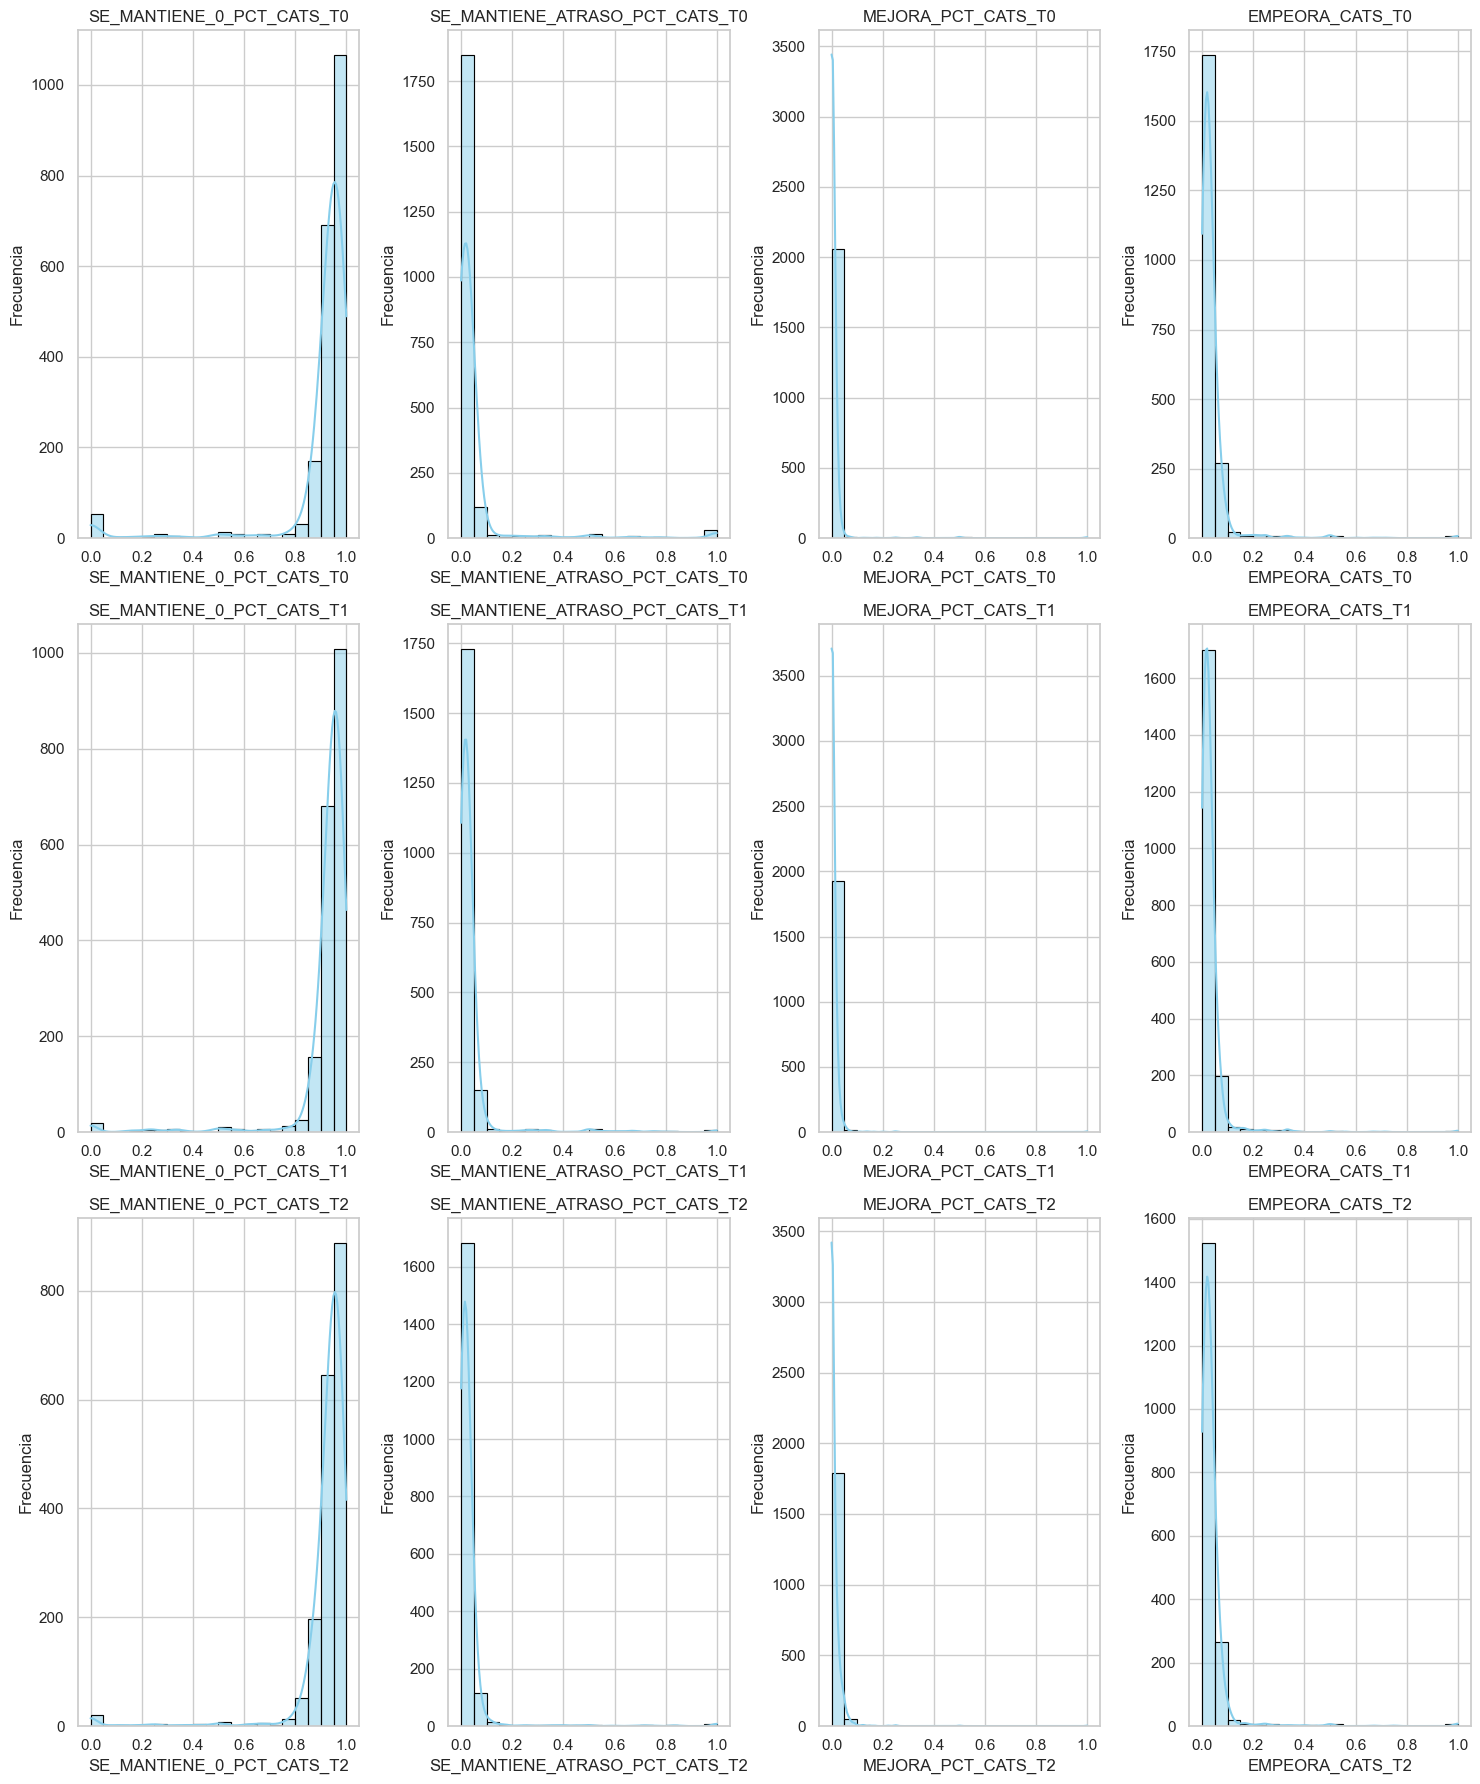

In [608]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(3, 4, figsize=(15, 18))

axes = axes.flatten()
for i, columna in enumerate(resultadosContratos.iloc[:,1:].columns):
    sns.histplot(resultadosContratos[columna], bins=20, kde=True, color='skyblue', edgecolor='black', ax=axes[i])
    axes[i].set_title(f'{columna}')
    axes[i].set_xlabel(columna)
    axes[i].set_ylabel('Frecuencia')
    axes[i].grid(True)
plt.tight_layout()
plt.show()

In [609]:
dfAsesorInt = merge_dataframes(df,dfFPD, dfCapta, dfVC, dfColocacion, dfMetricas, dfCalidad, dfCartera, dfAtraso, dfTiempoNegocio, dfGenero, dfSector,
                              dfMontoPrestado, dfDesembolso, dfDeterioroCarteraCopy, resultadosCartera, resultadosContratos)

In [610]:
dfAsesorInt.head()

,ASESOR_ID,PORC_CR_T20,PORC_CR_T21,PORC_CR_T10,PORC_CR_T22,PORC_CR_T4,PORC_CR_T29,PORC_CR_T28,PORC_CR_T16,PORC_CR_T23,PORC_CR_T8,PORC_CR_T13,PORC_CR_T6,PORC_CR_T19,PORC_CR_T30,PORC_CR_T11,PORC_CR_T15,PORC_CR_T2,PORC_CR_T12,PORC_CR_T3,PORC_CR_T0,PORC_CR_T7,PORC_CR_T26,PORC_CR_T27,PORC_CR_T18,PORC_CR_T14,PORC_CR_T5,PORC_CR_T9,PORC_CR_T25,PORC_CR_T17,PORC_CR_T1,PORC_CR_T24,POSITION_DESC,ANT_ASESOR,C_COBRANZA_T0,C_COBRANZA_T1,C_COBRANZA_T2,HORAS_VUELO,PORCT_RENOV_T2,PORCT_RENOV_T1,PORCT_RENOV_T0,ANT_ASESOR_RANGO,ANT_ASESOR_RANGO_NUM,PCNT_FPD_T2,PCNT_FPD_T1,PCNT_FPD_T0,TOT_AMI_T2,TOT_AMI_T1,TOT_AMI_T0,TOT_MAC_T2,TOT_MAC_T1,TOT_MAC_T0,TOT_SINVC_T2,TOT_SINVC_T1,TOT_SINVC_T0,TOT_VC_T2,TOT_VC_T1,TOT_VC_T0,DESEMBOLSOS_SIN_EXP_T2,DESEMBOLSOS_CON_EXP_T2,DESEMBOLSOS_SIN_EXP_T1,DESEMBOLSOS_CON_EXP_T1,DESEMBOLSOS_SIN_EXP_T0,DESEMBOLSOS_CON_EXP_T0,AVG_CICLOS_EJE_T2,AVG_CICLOS_EJE_T1,AVG_CICLOS_EJE_T0,AVG_CICLOS_CI_T2,AVG_CICLOS_CI_T1,AVG_CICLOS_CI_T0,CLIENTES_T2,CLIENTES_T1,CLIENTES_T0,CLIENTES_EXPERIENCIA_GRUPAL_T2,CLIENTES_EXPERIENCIA_GRUPAL_T1,CLIENTES_EXPERIENCIA_GRUPAL_T0,NUEVOS_PRODUCTO_T2,NUEVOS_PRODUCTO_T1,NUEVOS_PRODUCTO_T0,NUEVOS_PUROS_T2,NUEVOS_PUROS_T1,NUEVOS_PUROS_T0,SEGURO_FAMILIAR_T2,SEGURO_FAMILIAR_T1,SEGURO_FAMILIAR_T0,SEGURO_VOLUNTARIO_T2,SEGURO_VOLUNTARIO_T1,SEGURO_VOLUNTARIO_T0,MONTO_CARTERA_T2,MONTO_CARTERA_T1,MONTO_CARTERA_T0,CTES0_SIN_EXP_T2,CTES0_CON_EXP_T2,CTES1A7_SIN_EXP_T2,CTES1A7_CON_EXP_T2,CTES8A60_SIN_EXP_T2,CTES8A60_CON_EXP_T2,CTES60M_SIN_EXP_T2,CTES60M_CON_EXP_T2,CTES0_SIN_EXP_T1,CTES0_CON_EXP_T1,CTES1A7_SIN_EXP_T1,CTES1A7_CON_EXP_T1,CTES8A60_SIN_EXP_T1,CTES8A60_CON_EXP_T1,CTES60M_SIN_EXP_T1,CTES60M_CON_EXP_T1,CTES0_SIN_EXP_T0,CTES0_CON_EXP_T0,CTES1A7_SIN_EXP_T0,CTES1A7_CON_EXP_T0,CTES8A60_SIN_EXP_T0,CTES8A60_CON_EXP_T0,CTES60M_SIN_EXP_T0,CTES60M_CON_EXP_T0,CR0_SIN_EXP_T2,CR0_CON_EXP_T2,CR1A7_SIN_EXP_T2,CR1A7_CON_EXP_T2,CR8A60_SIN_EXP_T2,CR8A60_CON_EXP_T2,CR60M_SIN_EXP_T2,CR60M_CON_EXP_T2,CR0_SIN_EXP_T1,CR0_CON_EXP_T1,CR1A7_SIN_EXP_T1,CR1A7_CON_EXP_T1,CR8A60_SIN_EXP_T1,CR8A60_CON_EXP_T1,CR60M_SIN_EXP_T1,CR60M_CON_EXP_T1,CR0_SIN_EXP_T0,CR0_CON_EXP_T0,CR1A7_SIN_EXP_T0,CR1A7_CON_EXP_T0,CR8A60_SIN_EXP_T0,CR8A60_CON_EXP_T0,CR60M_SIN_EXP_T0,CR60M_CON_EXP_T0,CONTRATOS_SIN_EXP_T2,CONTRATOS_CON_EXP_T2,CONTRATOS_SIN_EXP_T1,CONTRATOS_CON_EXP_T1,CONTRATOS_SIN_EXP_T0,CONTRATOS_CON_EXP_T0,CARTERA_SIN_EXP_T2,CARTERA_CON_EXP_T2,CARTERA_SIN_EXP_T1,CARTERA_CON_EXP_T1,CARTERA_SIN_EXP_T0,CARTERA_CON_EXP_T0,AVG_ATRASO_ACT_EXP_T2,AVG_ATRASO_ACT_EXP_T1,AVG_ATRASO_ACT_EXP_T0,AVG_ATRASO_ACT_SIN_EXP_T2,AVG_ATRASO_ACT_SIN_EXP_T1,AVG_ATRASO_ACT_SIN_EXP_T0,TIME_BUSINESS_INDEFINIDO,TIME_BUSINESS_DEFAULT,TIME_BUSINESS_2,TIME_BUSINESS_3,TIME_BUSINESS_4,TIME_BUSINESS_5,EDAD_MASCULINO,EDAD_FEMENINO,PORC_FEMENINO,SECTOR_8,SECTOR_22,SECTOR_28,SECTOR_30,MONTO_PRESTADO_PROMEDIO_SE_T2,MONTO_PRESTADO_PROMEDIO_CE_T2,MONTO_PRESTADO_PROMEDIO_SE_T1,MONTO_PRESTADO_PROMEDIO_CE_T1,MONTO_PRESTADO_PROMEDIO_SE_T0,MONTO_PRESTADO_PROMEDIO_CE_T0,PCNT_DESEMBOLSO_TDD,DETERIORO8A60_T2,DETERIORO8A60_T1,DETERIORO8A60_T0,SE_MANTIENE_0_PCT_T0,SE_MANTIENE_ATRASO_PCT_T0,MEJORA_PCT_T0,EMPEORA_T0,SE_MANTIENE_0_PCT_T1,SE_MANTIENE_ATRASO_PCT_T1,MEJORA_PCT_T1,EMPEORA_T1,SE_MANTIENE_0_PCT_T2,SE_MANTIENE_ATRASO_PCT_T2,MEJORA_PCT_T2,EMPEORA_T2,SE_MANTIENE_0_PCT_CATS_T0,SE_MANTIENE_ATRASO_PCT_CATS_T0,MEJORA_PCT_CATS_T0,EMPEORA_CATS_T0,SE_MANTIENE_0_PCT_CATS_T1,SE_MANTIENE_ATRASO_PCT_CATS_T1,MEJORA_PCT_CATS_T1,EMPEORA_CATS_T1,SE_MANTIENE_0_PCT_CATS_T2,SE_MANTIENE_ATRASO_PCT_CATS_T2,MEJORA_PCT_CATS_T2,EMPEORA_CATS_T2
0,1949827,0.000000,0.000000,0.048167,0.000000,0.020897,0.000000,0.000000,0.095078,0.000000,0.043097,0.019886,0.033791,0.000000,0.000000,0.037748,0.057905,0.033106,0.048462,0.042283,0.014907,0.059170,0.000000,0.000000,0.000000,0.037075,0.018219,0.035683,0.000000,0.093738,0.046429,0.000000,ASESOR CI,254,6.0,6.0,3.0,307,0.0,0.250000,0.0,g.>=37,6,0.142857,0.151261,0.137255,2,2,3,126,130,130,121.0,123.0,123.0,5.0,7.0,7.0,12,1,13,3,13,4,4.706349,5.307692,5.330769,2.269841,2.3

In [611]:
dfAsesorInt.shape

(1613, 204)

## Validaciones

In [612]:
lsCartera_T2 = ['ASESOR_ID',
                'CR0_SIN_EXP_T2',
                'CR0_CON_EXP_T2',
                'CR1A7_SIN_EXP_T2',
                'CR1A7_CON_EXP_T2',
                'CR8A60_SIN_EXP_T2',
                'CR8A60_CON_EXP_T2',
                'CR60M_SIN_EXP_T2',
                'CR60M_CON_EXP_T2'
               ]
lsCartera_T1 = ['ASESOR_ID',
                'CR0_SIN_EXP_T1',
                'CR0_CON_EXP_T1',
                'CR1A7_SIN_EXP_T1',
                'CR1A7_CON_EXP_T1',
                'CR8A60_SIN_EXP_T1',
                'CR8A60_CON_EXP_T1',
                'CR60M_SIN_EXP_T1',
                'CR60M_CON_EXP_T1'
               ]
lsCartera_T0 = ['ASESOR_ID',
                'CR0_SIN_EXP_T0',
                'CR0_CON_EXP_T0',
                'CR1A7_SIN_EXP_T0',
                'CR1A7_CON_EXP_T0',
                'CR8A60_SIN_EXP_T0',
                'CR8A60_CON_EXP_T0',
                'CR60M_SIN_EXP_T0',
                'CR60M_CON_EXP_T0'
               ]

In [613]:
## Válida Composicion de cartera, con experiencia y sin experiencia en las 3 observaciones
##### T2
dfCarteraT2 = dfAsesorInt[lsCartera_T2 + ['MONTO_CARTERA_T2']]
dfCarteraT2['validaCr_T2'] = dfCarteraT2.iloc[:,1:-1].sum(axis=1)
print(dfCarteraT2['validaCr_T2'].sum() == dfCarteraT2['MONTO_CARTERA_T2'].sum())

##### T1
dfCarteraT1 = dfAsesorInt[lsCartera_T1 + ['MONTO_CARTERA_T1']]
dfCarteraT1['validaCr_T1'] = dfCarteraT1.iloc[:,1:-1].sum(axis=1)
print(dfCarteraT1['validaCr_T1'].sum() == dfCarteraT1['MONTO_CARTERA_T1'].sum())

##### T0
dfCarteraT0 = dfAsesorInt[lsCartera_T0 + ['MONTO_CARTERA_T0']]
dfCarteraT0['validaCr_T0'] = dfCarteraT0.iloc[:,1:-1].sum(axis=1)
print(dfCarteraT0['validaCr_T0'].sum() == dfCarteraT0['MONTO_CARTERA_T0'].sum())

False
False
True


In [614]:
dfCarteraT2['validaCRT2'] = dfCarteraT2['MONTO_CARTERA_T2']== dfCarteraT2['validaCr_T2']

In [615]:
dfCarteraT2[dfCarteraT2.validaCRT2==False]

,ASESOR_ID,CR0_SIN_EXP_T2,CR0_CON_EXP_T2,CR1A7_SIN_EXP_T2,CR1A7_CON_EXP_T2,CR8A60_SIN_EXP_T2,CR8A60_CON_EXP_T2,CR60M_SIN_EXP_T2,CR60M_CON_EXP_T2,MONTO_CARTERA_T2,validaCr_T2,validaCRT2
3,1950569,7063967.95,3593484.47,0.00,0.00,201534.62,21002.53,0.00,0.0,10879989.57,10879989.57,False
4,1950587,2881801.62,3221230.42,113426.10,38162.11,45942.88,0.00,53290.89,0.0,6353854.02,6353854.02,False
5,1951362,6534948.48,4458991.85,33109.90,0.00,177915.00,68913.78,0.00,0.0,11273879.01,11273879.01,False
6,1951589,2175366.68,7754023.69,0.00,0.00,257892.64,38929.06,1309.92,0.0,10227521.99,10227521.99,False
7,1951736,5475217.34,5092474.20,71723.86,62671.29,4389.00,0.00,0.00,0.0,10706475.69,10706475.69,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1598,94076490,3981984.54,2518435.99,52889.93,23886.84,283958.26,51969.38,0.00,0.0,6913124.94,6913124.94,False
1601,94115843,1995197.64,0.00,0.00,0.00,89390.73,0.00,0.00,0.0,2084588.37,2084588.37,False
1602,94115849,3704825.67,1257321.67,30805.60,0.00,91026.93,0.00,0.00,0.0,5083979.87,5083979.87,False
1604,94154246,2327711.88,1260301.55,67576.70,0.00,113800.55,23252.09,68640.94,0.0,3861283.71,3861283.71,False


In [616]:
lsClientes_T2 = ['ASESOR_ID',
                 'CTES0_SIN_EXP_T2',
                 'CTES0_CON_EXP_T2',
                 'CTES1A7_SIN_EXP_T2',
                 'CTES1A7_CON_EXP_T2',
                 'CTES8A60_SIN_EXP_T2',
                 'CTES8A60_CON_EXP_T2',
                 'CTES60M_SIN_EXP_T2',
                 'CTES60M_CON_EXP_T2'
                ]
lsClientes_T1 = ['ASESOR_ID',
                 'CTES0_SIN_EXP_T1',
                 'CTES0_CON_EXP_T1',
                 'CTES1A7_SIN_EXP_T1',
                 'CTES1A7_CON_EXP_T1',
                 'CTES8A60_SIN_EXP_T1',
                 'CTES8A60_CON_EXP_T1',
                 'CTES60M_SIN_EXP_T1',
                 'CTES60M_CON_EXP_T1'
                ]
lsClientes_T0 = ['ASESOR_ID',
                 'CTES0_SIN_EXP_T0',
                 'CTES0_CON_EXP_T0',
                 'CTES1A7_SIN_EXP_T0',
                 'CTES1A7_CON_EXP_T0',
                 'CTES8A60_SIN_EXP_T0',
                 'CTES8A60_CON_EXP_T0',
                 'CTES60M_SIN_EXP_T0',
                 'CTES60M_CON_EXP_T0'
                ]

In [617]:
## Válida Composicion de tipo de cliente, con experiencia y sin experiencia en las 3 observaciones
##### T2
dfCliT2 = dfAsesorInt[lsClientes_T2 + ['CLIENTES_T2']]
dfCliT2['validaCli_T2'] = dfCliT2.iloc[:,1:-1].sum(axis=1)
print(dfCliT2['validaCli_T2'].sum() == dfCliT2['CLIENTES_T2'].sum())

##### T1
dfCliT1 = dfAsesorInt[lsClientes_T1 + ['CLIENTES_T1']]
dfCliT1['validaCli_T1'] = dfCliT1.iloc[:,1:-1].sum(axis=1)
print(dfCliT1['validaCli_T1'].sum() == dfCliT1['CLIENTES_T1'].sum())

##### T0
dfCliT0 = dfAsesorInt[lsClientes_T0 + ['CLIENTES_T0']]
dfCliT0['validaCli_T0'] = dfCliT0.iloc[:,1:-1].sum(axis=1)
print(dfCliT0['validaCli_T0'].sum() == dfCliT0['CLIENTES_T0'].sum())

True
True
True


In [618]:
lsEliminar = [
    'CONTRATOS_SIN_EXP_T2',
    'CONTRATOS_CON_EXP_T2',
    'CONTRATOS_SIN_EXP_T1',
    'CONTRATOS_CON_EXP_T1',
    'CONTRATOS_SIN_EXP_T0',
    'CONTRATOS_CON_EXP_T0',
    'CARTERA_SIN_EXP_T2',
    'CARTERA_CON_EXP_T2',
    'CARTERA_SIN_EXP_T1',
    'CARTERA_CON_EXP_T1',
    'CARTERA_SIN_EXP_T0',
    'CARTERA_CON_EXP_T0',
    'CLIENTES_T2',
    'CLIENTES_T1',
    'CLIENTES_T0',
    'MONTO_CARTERA_T2',
    'MONTO_CARTERA_T1',
    'MONTO_CARTERA_T0'
             ]

In [619]:
dfAsesorInt.drop(columns=lsEliminar, inplace=True)

In [620]:
dfAsesorInt.shape

(1613, 186)

In [621]:
dfAsesorInt.head()

,ASESOR_ID,PORC_CR_T20,PORC_CR_T21,PORC_CR_T10,PORC_CR_T22,PORC_CR_T4,PORC_CR_T29,PORC_CR_T28,PORC_CR_T16,PORC_CR_T23,PORC_CR_T8,PORC_CR_T13,PORC_CR_T6,PORC_CR_T19,PORC_CR_T30,PORC_CR_T11,PORC_CR_T15,PORC_CR_T2,PORC_CR_T12,PORC_CR_T3,PORC_CR_T0,PORC_CR_T7,PORC_CR_T26,PORC_CR_T27,PORC_CR_T18,PORC_CR_T14,PORC_CR_T5,PORC_CR_T9,PORC_CR_T25,PORC_CR_T17,PORC_CR_T1,PORC_CR_T24,POSITION_DESC,ANT_ASESOR,C_COBRANZA_T0,C_COBRANZA_T1,C_COBRANZA_T2,HORAS_VUELO,PORCT_RENOV_T2,PORCT_RENOV_T1,PORCT_RENOV_T0,ANT_ASESOR_RANGO,ANT_ASESOR_RANGO_NUM,PCNT_FPD_T2,PCNT_FPD_T1,PCNT_FPD_T0,TOT_AMI_T2,TOT_AMI_T1,TOT_AMI_T0,TOT_MAC_T2,TOT_MAC_T1,TOT_MAC_T0,TOT_SINVC_T2,TOT_SINVC_T1,TOT_SINVC_T0,TOT_VC_T2,TOT_VC_T1,TOT_VC_T0,DESEMBOLSOS_SIN_EXP_T2,DESEMBOLSOS_CON_EXP_T2,DESEMBOLSOS_SIN_EXP_T1,DESEMBOLSOS_CON_EXP_T1,DESEMBOLSOS_SIN_EXP_T0,DESEMBOLSOS_CON_EXP_T0,AVG_CICLOS_EJE_T2,AVG_CICLOS_EJE_T1,AVG_CICLOS_EJE_T0,AVG_CICLOS_CI_T2,AVG_CICLOS_CI_T1,AVG_CICLOS_CI_T0,CLIENTES_EXPERIENCIA_GRUPAL_T2,CLIENTES_EXPERIENCIA_GRUPAL_T1,CLIENTES_EXPERIENCIA_GRUPAL_T0,NUEVOS_PRODUCTO_T2,NUEVOS_PRODUCTO_T1,NUEVOS_PRODUCTO_T0,NUEVOS_PUROS_T2,NUEVOS_PUROS_T1,NUEVOS_PUROS_T0,SEGURO_FAMILIAR_T2,SEGURO_FAMILIAR_T1,SEGURO_FAMILIAR_T0,SEGURO_VOLUNTARIO_T2,SEGURO_VOLUNTARIO_T1,SEGURO_VOLUNTARIO_T0,CTES0_SIN_EXP_T2,CTES0_CON_EXP_T2,CTES1A7_SIN_EXP_T2,CTES1A7_CON_EXP_T2,CTES8A60_SIN_EXP_T2,CTES8A60_CON_EXP_T2,CTES60M_SIN_EXP_T2,CTES60M_CON_EXP_T2,CTES0_SIN_EXP_T1,CTES0_CON_EXP_T1,CTES1A7_SIN_EXP_T1,CTES1A7_CON_EXP_T1,CTES8A60_SIN_EXP_T1,CTES8A60_CON_EXP_T1,CTES60M_SIN_EXP_T1,CTES60M_CON_EXP_T1,CTES0_SIN_EXP_T0,CTES0_CON_EXP_T0,CTES1A7_SIN_EXP_T0,CTES1A7_CON_EXP_T0,CTES8A60_SIN_EXP_T0,CTES8A60_CON_EXP_T0,CTES60M_SIN_EXP_T0,CTES60M_CON_EXP_T0,CR0_SIN_EXP_T2,CR0_CON_EXP_T2,CR1A7_SIN_EXP_T2,CR1A7_CON_EXP_T2,CR8A60_SIN_EXP_T2,CR8A60_CON_EXP_T2,CR60M_SIN_EXP_T2,CR60M_CON_EXP_T2,CR0_SIN_EXP_T1,CR0_CON_EXP_T1,CR1A7_SIN_EXP_T1,CR1A7_CON_EXP_T1,CR8A60_SIN_EXP_T1,CR8A60_CON_EXP_T1,CR60M_SIN_EXP_T1,CR60M_CON_EXP_T1,CR0_SIN_EXP_T0,CR0_CON_EXP_T0,CR1A7_SIN_EXP_T0,CR1A7_CON_EXP_T0,CR8A60_SIN_EXP_T0,CR8A60_CON_EXP_T0,CR60M_SIN_EXP_T0,CR60M_CON_EXP_T0,AVG_ATRASO_ACT_EXP_T2,AVG_ATRASO_ACT_EXP_T1,AVG_ATRASO_ACT_EXP_T0,AVG_ATRASO_ACT_SIN_EXP_T2,AVG_ATRASO_ACT_SIN_EXP_T1,AVG_ATRASO_ACT_SIN_EXP_T0,TIME_BUSINESS_INDEFINIDO,TIME_BUSINESS_DEFAULT,TIME_BUSINESS_2,TIME_BUSINESS_3,TIME_BUSINESS_4,TIME_BUSINESS_5,EDAD_MASCULINO,EDAD_FEMENINO,PORC_FEMENINO,SECTOR_8,SECTOR_22,SECTOR_28,SECTOR_30,MONTO_PRESTADO_PROMEDIO_SE_T2,MONTO_PRESTADO_PROMEDIO_CE_T2,MONTO_PRESTADO_PROMEDIO_SE_T1,MONTO_PRESTADO_PROMEDIO_CE_T1,MONTO_PRESTADO_PROMEDIO_SE_T0,MONTO_PRESTADO_PROMEDIO_CE_T0,PCNT_DESEMBOLSO_TDD,DETERIORO8A60_T2,DETERIORO8A60_T1,DETERIORO8A60_T0,SE_MANTIENE_0_PCT_T0,SE_MANTIENE_ATRASO_PCT_T0,MEJORA_PCT_T0,EMPEORA_T0,SE_MANTIENE_0_PCT_T1,SE_MANTIENE_ATRASO_PCT_T1,MEJORA_PCT_T1,EMPEORA_T1,SE_MANTIENE_0_PCT_T2,SE_MANTIENE_ATRASO_PCT_T2,MEJORA_PCT_T2,EMPEORA_T2,SE_MANTIENE_0_PCT_CATS_T0,SE_MANTIENE_ATRASO_PCT_CATS_T0,MEJORA_PCT_CATS_T0,EMPEORA_CATS_T0,SE_MANTIENE_0_PCT_CATS_T1,SE_MANTIENE_ATRASO_PCT_CATS_T1,MEJORA_PCT_CATS_T1,EMPEORA_CATS_T1,SE_MANTIENE_0_PCT_CATS_T2,SE_MANTIENE_ATRASO_PCT_CATS_T2,MEJORA_PCT_CATS_T2,EMPEORA_CATS_T2
0,1949827,0.000000,0.000000,0.048167,0.000000,0.020897,0.000000,0.000000,0.095078,0.000000,0.043097,0.019886,0.033791,0.000000,0.000000,0.037748,0.057905,0.033106,0.048462,0.042283,0.014907,0.059170,0.000000,0.000000,0.000000,0.037075,0.018219,0.035683,0.000000,0.093738,0.046429,0.000000,ASESOR CI,254,6.0,6.0,3.0,307,0.0,0.250000,0.0,g.>=37,6,0.142857,0.151261,0.137255,2,2,3,126,130,130,121.0,123.0,123.0,5.0,7.0,7.0,12,1,13,3,13,4,4.706349,5.307692,5.330769,2.269841,2.346154,2.430769,27,30,28,3,6,4,3,3,3,79,68,52,81,70,54,108,14,0,0,3,1,0,0,106,14,0,0,8,2,0,0,109,15,0,0,6,0,0,0,4648576.31,1325116.39,0.00,0.00,184632.25,19902.36,0.00,0.0,5093836.26,1500735.00,0.00,0.00,289462.08,31627.25,0.00,0.0,5259009.85,1512238.80,0.00,0.00,102469.10,0.00,0.0,0.0,0.909910,2.201754,2.539130,1.600000,5.187

In [622]:
dfAsesorInt.to_parquet(os.path.join(rutas.get('interimData'),'Sabana_integrada_asesor_ScoreCI_abr25.parquet'), index=False)